In [1]:
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
pd.options.display.max_rows = 99999

def load_data_intraday(filename):
    """
    Funzione per il parsing di una serie intraday 
    con estensione txt esportata da Tradestation
    """
    data = pd.read_csv(filename, 
                       usecols=['Date','Time','Open','High','Low','Close','Up','Down'], 
                       parse_dates=[['Date', 'Time']], )
    data.columns = ["date_time","open","high","low","close","up","down"]
    data.set_index('date_time', inplace = True)
    data['volume'] = data['up'] + data['down']
    data.drop(['up','down'],axis=1,inplace=True)
    data["dayofweek"] = data.index.dayofweek
    data["day"] = data.index.day
    data["month"] = data.index.month
    data["year"] = data.index.year
    data["dayofyear"] = data.index.dayofyear
    data["quarter"] = data.index.quarter
    data["hour"] = data.index.hour
    data["minute"] = data.index.minute
    return data

def load_data_daily(filename):
    """
    Funzione per il caricamento di uno storico daily
    Fonte dati: Tradestation .txt
    """
    data = pd.read_csv(filename, parse_dates = ["Date","Time"])
    data.columns = ["date","time","open","high","low","close","volume","oi"]
    data.set_index("date", inplace = True)
    data.drop(["time","oi"], axis=1, inplace=True)
    data["dayofweek"] = data.index.dayofweek
    data["day"] = data.index.day
    data["month"] = data.index.month
    data["year"] = data.index.year
    data["dayofyear"] = data.index.dayofyear
    data["quarter"] = data.index.quarter
    return data
    
def crossover(array1, array2):
    return (array1 > array2) & (array1.shift(1) < array2.shift(1))

def crossunder(array1, array2):
    return (array1 < array2) & (array1.shift(1) > array2.shift(1))
        
def plot_equity(equity,color):
    """
    Funzione per stampare un'equity line
    """
    plt.figure(figsize=(14, 8), dpi=300)
    plt.plot(equity, color=color)
    plt.xlabel("Time")
    plt.ylabel("Profit/Loss")
    plt.title('Equity Line')
    plt.xticks(rotation='vertical')
    plt.grid(True)
    plt.show()
    return
    
def drawdown(equity):
    """
    Funzione che calcola il draw down data un'equity line
    """
    maxvalue = equity.expanding(0).max()
    drawdown = equity - maxvalue
    drawdown_series = pd.Series(drawdown, index = equity.index)
    return drawdown_series

def plot_drawdown(equity,color):
    """
    Funzione per graficare la curva di draw down
    """
    dd = drawdown(equity)
    plt.figure(figsize = (12, 6), dpi = 300)
    plt.plot(dd, color = color)
    plt.fill_between(dd.index, 0, dd, color = color)
    plt.xlabel("Time")
    plt.ylabel("Profit/Loss")
    plt.title('Draw Down')
    plt.xticks(rotation='vertical')
    plt.grid(True)
    plt.show()
    return
    
def plot_double_equity(closed_equity,open_equity):
    """
    Funzione per stampare due equity sovrapposte
    """
    plt.figure(figsize=(14, 8), dpi=300)
    plt.plot(open_equity, color='red')
    plt.plot(closed_equity, color='green')
    plt.xlabel("Time")
    plt.ylabel("Profit/Loss")
    plt.title('Open & Closed Equity Line')
    plt.xticks(rotation='vertical')
    plt.grid(True)
    plt.show()
    return
    
def profit(equity):
    return round(equity[-1],2)
    
def operation_number(operations):
    return operations.count()
    
def avg_trade(operations):
    return round(operations.mean(),2)
    
def max_draw_down(equity):
    dd = drawdown(equity)
    return round(dd.min(),2)
    
def avgdrawdown_nozero(equity):
    """
    calcola la media del draw down storico
    non considerando i valori nulli (nuovi massimi di equity line)
    """
    dd = drawdown(equity)
    return round(dd[dd < 0].mean(),2)

def avg_loss(operations):
    return round(operations[operations < 0].mean(),2)
    
def max_loss(operations):
    return round(operations.min(),2)
    
def max_loss_date(operations):
    return operations.idxmin()
    
def avg_gain(operations):
    return round(operations[operations > 0].mean(),2)
    
def max_gain(operations):
    return round(operations.max(),2)
    
def max_gain_date(operations):
    return operations.idxmax()
    
def gross_profit(operations):
    return round(operations[operations > 0].sum(),2)
    
def gross_loss(operations):
    return round(operations[operations <= 0].sum(),2)
    
def profit_factor(operations):
    a = gross_profit(operations)
    b = gross_loss(operations)
    if b != 0:
        return round(abs(a / b), 2)
    else:
        return round(abs(a / 0.00000001), 2)
        
def percent_win(operations):
    return round((operations[operations > 0].count() / operations.count() * 100),2)
    
def reward_risk_ratio(operations):
    if operations[operations <= 0].mean() != 0:
        return round((operations[operations > 0].mean() / -operations[operations <= 0].mean()),2)
    else:
        return np.inf
        
def delay_between_peaks(equity):
    """
    Funzione per calcolare i ritardi istantanei in barre
    nel conseguire nuovi massimi di equity line
    Input: equity line
    """
    work_df = pd.DataFrame(equity, index = equity.index)
    work_df["drawdown"] = drawdown(equity)
    work_df["delay_elements"] = work_df["drawdown"].apply(lambda x: 1 if x < 0 else 0)
    work_df["resets"] = np.where(work_df["drawdown"] == 0, 1, 0)
    work_df['cumsum'] = work_df['resets'].cumsum()
    #print(work_df.iloc[-20:,:])
    a = pd.Series(work_df['delay_elements'].groupby(work_df['cumsum']).cumsum())
    return a

def max_delay_between_peaks(equity):
    """
    Funzione per calcolare il più lungo ritardo in barre dall'ultimo massimo
    Input: equity line
    """
    a = delay_between_peaks(equity)
    return a.max()
    
def avg_delay_between_peaks(equity):
    """
    Funzione per calcolare il ritardo medio in barre
    nel conseguire nuovi massimi di equity line
    Input: equity line
    """
    work_df = pd.DataFrame(equity, index = equity.index)
    work_df["drawdown"] = drawdown(equity)
    work_df["delay_elements"] = work_df["drawdown"].apply(lambda x: 1 if x < 0 else np.nan)
    work_df["resets"] = np.where(work_df["drawdown"] == 0, 1, 0)
    work_df['cumsum'] = work_df['resets'].cumsum()
    work_df.dropna(inplace = True)
    a = work_df['delay_elements'].groupby(work_df['cumsum']).sum()
    return round(a.mean(),2)
    
def plot_annual_histogram(operations):
    yearly = operations.resample('A').sum()
    colors = pd.Series()
    colors = yearly.apply(lambda x: "green" if x > 0 else "red")
    n_groups = len(yearly)
    plt.subplots(figsize=(10, 7), dpi=200)
    index = np.arange(n_groups)
    bar_width = 0.35
    opacity = 1

    rects1 = plt.bar(index,
                     yearly,
                     bar_width,
                     alpha=opacity,
                     color=colors,
                     label='Yearly Statistics')

    plt.xlabel('Years')
    plt.ylabel('Profit - Loss')
    plt.title('Yearly Profit-Loss - by Gandalf Project R&D')
    plt.xticks(index, yearly.index.year, rotation=90)
    plt.grid(True)
    plt.show()
    return
    
def plot_monthly_bias_histogram(operations):
    monthly = pd.DataFrame(operations.fillna(0)).resample('M').sum()
    monthly['Month'] = monthly.index.month
    biasMonthly = []
    months = []

    for month in range(1, 13):
        months.append(month)
    for month in months:
        biasMonthly.append(monthly[(monthly['Month'] == month)].mean())

    biasMonthly = pd.DataFrame(biasMonthly)
    column = biasMonthly.columns[0]
    colors = pd.Series()
    colors = biasMonthly[column].apply(lambda x: "green" if x > 0 else "red")
    n_groups = len(biasMonthly)
    plt.subplots(figsize=(14, 6), dpi=300)
    index = np.arange(n_groups)
    bar_width = 0.35
    opacity = 1

    rects1 = plt.bar(index,
                     biasMonthly[column],
                     bar_width,
                     alpha=opacity,
                     color=colors,
                     label='Yearly Statistics')

    plt.xlabel('Months')
    plt.ylabel('Average Profit - Loss')
    plt.title('Average Monthly Profit-Loss - by Gandalf Project R&D')
    months_names = ["January", "February", "March", "April", "May", "June", "July", "August", "September",
                    "October", "November", "December"]
    plt.xticks(index, months_names, rotation=45)
    plt.grid(True)
    plt.show()
    return
    
def plot_equity_heatmap(operations,annotations):
    monthly = operations.resample('M').sum()
    toHeatMap = pd.DataFrame(monthly)
    toHeatMap["Year"] = toHeatMap.index.year
    toHeatMap["Month"] = toHeatMap.index.month
    Show = toHeatMap.groupby(by=['Year','Month']).sum().unstack()
    Show.columns = ["January","February","March","April","May","June",
                    "July","August","September","October","November","December"]
    plt.figure(figsize=(8,6),dpi=120)
    sns.heatmap(Show, cmap="RdYlGn", linecolor="white", linewidth=0.1, annot=annotations, 
                vmin=-max(monthly.min(),monthly.max()), vmax=monthly.max())
    return
    
def performance_report(trading_system,operations,closed_equity,open_equity):
    print("Performance Report - by Gandalf Project R&D")
    print("")
    print("Profit:                  ", profit(open_equity))
    print("Operations:              ", operation_number(operations))
    print("Average Trade:           ", avg_trade(operations))
    print("")
    print("Profit Factor:           ", profit_factor(operations))
    print("Gross Profit:            ", gross_profit(operations))
    print("Gross Loss:              ", gross_loss(operations))
    print("")
    print("Percent Winning Trades:  ", percent_win(operations))
    print("Percent Losing Trades:   ", 100 - percent_win(operations))
    print("Reward Risk Ratio:       ", reward_risk_ratio(operations))
    print("")
    print("Max Gain:                ", max_gain(operations), " in date ", max_gain_date(operations))
    print("Average Gain:            ", avg_gain(operations))
    print("Max Loss:                ", max_loss(operations), " in date ", max_loss_date(operations))
    print("Average Loss:            ", avg_loss(operations))
    print("")
    print("Avg Open Draw Down:      ", avgdrawdown_nozero(open_equity))
    print("Max Open Draw Down:      ", max_draw_down(open_equity))
    print("")
    print("Avg Closed Draw Down:    ", avgdrawdown_nozero(trading_system.closed_equity))
    print("Max Closed Draw Down:    ", max_draw_down(trading_system.closed_equity))
    print("")
    print("Avg Delay Between Peaks: ", avg_delay_between_peaks(trading_system.open_equity))
    print("Max Delay Between Peaks: ", max_delay_between_peaks(trading_system.open_equity))
    plot_equity(trading_system.open_equity,"green")
    plot_drawdown(trading_system.open_equity,"red")
    plot_annual_histogram(operations)
    plot_monthly_bias_histogram(operations)
    plot_equity_heatmap(operations,False)
    return

import math

def tick_correction_up(level,tick):
    if level != level:
        level = 0
    multiplier = math.ceil(level/tick)
    return multiplier * tick

def tick_correction_down(level,tick):
    if level != level:
        level = 0
    multiplier = math.floor(level/tick)
    return multiplier * tick

In [2]:
def stop_check(dataframe,rules,level,direction):
    """
    Funzione per validare una regola di ingresso o di uscita rispetto ad un setup stop
    Viene verificata il superamento del massimo (long) o minimo (short) sul level
    """
    service_dataframe = pd.DataFrame(index = dataframe.index)
    service_dataframe['rules'] = rules
    service_dataframe['level'] = level
    service_dataframe['low'] = dataframe.low
    service_dataframe['high'] = dataframe.high

    if direction == "long":
        service_dataframe['new_rules'] = np.where((service_dataframe.rules == True) &\
                                                  (service_dataframe.high.shift(-1) >= service_dataframe.level.shift(-1)), 
                                                  True, False)
    if direction == "short":
        service_dataframe['new_rules'] = np.where((service_dataframe.rules == True) &\
                                                  (service_dataframe.low.shift(-1) <= service_dataframe.level.shift(-1)), 
                                                  True, False)
    return service_dataframe.new_rules

def limit_check(dataframe,rules,level,direction):
    """
    Funzione per validare una regola di ingresso o di uscita rispetto ad un setup limit
    Viene verificata il raggiungimento del minimo (long) o massimo (short) sul level
    """
    service_dataframe = pd.DataFrame()
    service_dataframe['rules'] = rules
    service_dataframe['level'] = level
    service_dataframe['low'] = dataframe.low
    service_dataframe['high'] = dataframe.high
    
    if direction == "long":
        service_dataframe['new_rules'] = np.where((service_dataframe.rules == True) & \
                                                  (service_dataframe.low.shift(-1) <= service_dataframe.level.shift(-1)), 
                                                  True, False)
    if direction == "short":
        service_dataframe['new_rules'] = np.where((service_dataframe.rules == True) &
                                                  (service_dataframe.high.shift(-1) >= service_dataframe.level.shift(-1)), 
                                                  True, False)
    return service_dataframe.new_rules

In [3]:
def marketposition_generator(enter_rules,exit_rules):
    """
    Funzione per calcolare il marketposition date due serie di enter_rules and exit_rules
    """
    service_dataframe = pd.DataFrame(index = enter_rules.index)
    service_dataframe['enter_rules'] = enter_rules
    service_dataframe['exit_rules'] = exit_rules
    
    status = 0
    mp = []
    for (i, j) in zip(enter_rules, exit_rules):
        if status == 0:
            if i == 1 and j != -1:
                status = 1
        else:
            if j == -1:
                status = 0
        mp.append(status)
        
    service_dataframe['mp_new'] = mp
    service_dataframe.mp_new = service_dataframe.mp_new.shift(1)
    service_dataframe.iloc[0,2] = 0
    service_dataframe.to_csv("marketposition_generator.csv")
    return service_dataframe.mp_new

In [4]:
def apply_trading_system(imported_dataframe, bigpointvalue, tick, direction, order_type, 
                         enter_level, enter_rules, exit_rules):
    
    dataframe = imported_dataframe.copy()
    
    if ORDER_TYPE == "stop":
        enter_rules = stop_check(dataframe,enter_rules,enter_level,direction)
    if ORDER_TYPE == "limit":
        enter_rules = limit_check(dataframe,enter_rules,enter_level,direction)
        
    dataframe['enter_level'] = enter_level
    dataframe['enter_rules'] = enter_rules.apply(lambda x: 1 if x == True else 0)
    dataframe['exit_rules'] = exit_rules.apply(lambda x: -1 if x == True else 0)
    
    dataframe["mp"] = marketposition_generator(dataframe.enter_rules,dataframe.exit_rules)
 
    if ORDER_TYPE == "market":
        dataframe["entry_price"] = np.where((dataframe.mp.shift(1) == 0) & (dataframe.mp == 1), 
                                             dataframe.open, np.nan)
        if INSTRUMENT == 1:
            dataframe["number_of_stocks"] = np.where((dataframe.mp.shift(1) == 0) & (dataframe.mp == 1), 
                                                      OPERATION_MONEY / dataframe.open, np.nan)
    if ORDER_TYPE == "stop":
        if direction == "long":
            dataframe.enter_level = dataframe.enter_level.apply(lambda x: tick_correction_up(x,tick))
            real_entry = np.where(dataframe.open > dataframe.enter_level, dataframe.open, dataframe.enter_level)
            dataframe["entry_price"] = np.where((dataframe.mp.shift(1) == 0) & (dataframe.mp == 1), 
                                                real_entry, np.nan)
        if direction == "short":
            dataframe.enter_level = dataframe.enter_level.apply(lambda x: tick_correction_down(x,tick))
            real_entry = np.where(dataframe.open < dataframe.enter_level, dataframe.open, dataframe.enter_level)
            dataframe["entry_price"] = np.where((dataframe.mp.shift(1) == 0) & (dataframe.mp == 1), 
                                                real_entry, np.nan)
        if INSTRUMENT == 1:
            dataframe["number_of_stocks"] = np.where((dataframe.mp.shift(1) == 0) & (dataframe.mp == 1), 
                                                      OPERATION_MONEY / real_entry, np.nan)   
    if ORDER_TYPE == "limit":
        if direction == "long":
            dataframe.enter_level = dataframe.enter_level.apply(lambda x: tick_correction_down(x,tick))
            real_entry = np.where(dataframe.open < dataframe.enter_level, dataframe.open, dataframe.enter_level)
            dataframe["entry_price"] = np.where((dataframe.mp.shift(1) == 0) & (dataframe.mp == 1), 
                                                real_entry, np.nan)
        if direction == "short":
            dataframe.enter_level = dataframe.enter_level.apply(lambda x: tick_correction_up(x,tick))
            real_entry = np.where(dataframe.open > dataframe.enter_level, dataframe.open, dataframe.enter_level)
            dataframe["entry_price"] = np.where((dataframe.mp.shift(1) == 0) & (dataframe.mp == 1), 
                                                real_entry, np.nan)
        if INSTRUMENT == 1:
            dataframe["number_of_stocks"] = np.where((dataframe.mp.shift(1) == 0) & (dataframe.mp == 1), 
                                                      OPERATION_MONEY / real_entry, np.nan)                                                      
        
    dataframe["entry_price"] = dataframe["entry_price"].fillna(method='ffill')
    dataframe["events_in"] = np.where((dataframe.mp == 1) & (dataframe.mp.shift(1) == 0), "entry", "")
    if INSTRUMENT == 1:
        dataframe["number_of_stocks"] = dataframe["number_of_stocks"].apply(lambda x: round(x,0))\
                                        .fillna(method='ffill')
        
    if direction == "long":
        if INSTRUMENT == 1:
            dataframe["open_operations"] = (dataframe.close - dataframe.entry_price) * dataframe.number_of_stocks
            dataframe["open_operations"] = np.where((dataframe.mp == 1) & (dataframe.mp.shift(-1) == 0), 
                                                    (dataframe.open.shift(-1) - dataframe.entry_price)
                                                    * dataframe.number_of_stocks - 2 * COSTS, 
                                                    dataframe.open_operations)
        if INSTRUMENT == 2:
            dataframe["open_operations"] = (dataframe.close - dataframe.entry_price) * bigpointvalue
            dataframe["open_operations"] = np.where((dataframe.mp == 1) & (dataframe.mp.shift(-1) == 0), 
                     (dataframe.open.shift(-1) - dataframe.entry_price) * bigpointvalue - 2 * COSTS,
                      dataframe.open_operations)
            
    if direction == "short":
        if INSTRUMENT == 1:
            dataframe["open_operations"] = (dataframe.entry_price - dataframe.close) * dataframe.number_of_stocks
            dataframe["open_operations"] = np.where((dataframe.mp == 1) & (dataframe.mp.shift(-1) == 0), 
                                            (dataframe.entry_price - dataframe.open.shift(-1))\
                                            * dataframe.number_of_stocks - 2 * COSTS,
                                            dataframe.open_operations)
        if INSTRUMENT == 2:
            dataframe["open_operations"] = (dataframe.entry_price - dataframe.close) * bigpointvalue
            dataframe["open_operations"] = np.where((dataframe.mp == 1) & (dataframe.mp.shift(-1) == 0), 
                     (dataframe.entry_price - dataframe.open.shift(-1)) * bigpointvalue - 2 * COSTS,
                      dataframe.open_operations)
        
    dataframe["open_operations"] = np.where(dataframe.mp == 1, dataframe.open_operations, 0)
    dataframe["events_out"] = np.where((dataframe.mp == 1) & (dataframe.exit_rules == -1), "exit", "")      
    dataframe["operations"] = np.where((dataframe.exit_rules == -1) & (dataframe.mp == 1), 
                                        dataframe.open_operations, np.nan)
    dataframe["closed_equity"] = dataframe.operations.fillna(0).cumsum()
    dataframe["open_equity"] = dataframe.closed_equity + \
                               dataframe.open_operations - dataframe.operations.fillna(0)
    dataframe.to_csv("trading_system_export.csv")
    return dataframe

In [5]:
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
pd.options.display.max_rows = 99999

IS_START_DATE = "20070101"
IS_END_DATE = "20140101"

OOS_START_DATE = "20140101"
OOS_END_DATE = "20190914"

IS_StartDateParsed = datetime.date(int(IS_START_DATE[0:4]), int(IS_START_DATE[4:6]), int(IS_START_DATE[6:]))
IS_EndDateParsed = datetime.date(int(IS_END_DATE[0:4]), int(IS_END_DATE[4:6]), int(IS_END_DATE[6:]))

OOS_StartDateParsed = datetime.date(int(OOS_START_DATE[0:4]), int(OOS_START_DATE[4:6]), int(OOS_START_DATE[6:]))
OOS_EndDateParsed = datetime.date(int(OOS_END_DATE[0:4]), int(OOS_END_DATE[4:6]), int(OOS_END_DATE[6:]))

dataset = load_data_intraday("@GC_15min_Exchange.txt")

dataset_IS = dataset.copy().loc[IS_StartDateParsed:IS_EndDateParsed]
dataset_OOS = dataset.copy().loc[OOS_StartDateParsed:OOS_EndDateParsed]

In [6]:
dataset_IS.count()

open         164555
high         164555
low          164555
close        164555
volume       164555
dayofweek    164555
day          164555
month        164555
year         164555
dayofyear    164555
quarter      164555
hour         164555
minute       164555
dtype: int64

In [7]:
dataset_IS.head()

,open,high,low,close,volume,dayofweek,day,month,year,dayofyear,quarter,hour,minute
date_time,,,,,,,,,,,,,
2007-01-01 18:15:00,860.2,861.3,860.1,860.1,751,0,1,1,2007,1,1,18,15
2007-01-01 18:30:00,860.3,860.3,859.5,859.9,132,0,1,1,2007,1,1,18,30
2007-01-01 18:45:00,859.5,860.3,859.5,860.3,133,0,1,1,2007,1,1,18,45
2007-01-01 19:00:00,860.0,860.3,860.0,860.2,6,0,1,1,2007,1,1,19,0
2007-01-01 19:15:00,859.9,860.0,859.5,860.0,68,0,1,1,2007,1,1,19,15


In [8]:
dataset_IS.tail()

,open,high,low,close,volume,dayofweek,day,month,year,dayofyear,quarter,hour,minute
date_time,,,,,,,,,,,,,
2013-12-31 16:00:00,1305.2,1308.4,1304.9,1307.8,524,1,31,12,2013,365,4,16,0
2013-12-31 16:15:00,1308.0,1310.1,1307.6,1309.4,544,1,31,12,2013,365,4,16,15
2013-12-31 16:30:00,1309.5,1309.5,1308.8,1308.8,89,1,31,12,2013,365,4,16,30
2013-12-31 16:45:00,1309.2,1309.2,1308.3,1308.3,132,1,31,12,2013,365,4,16,45
2013-12-31 17:00:00,1308.6,1309.6,1308.6,1309.0,90,1,31,12,2013,365,4,17,0


In [9]:
dataset_OOS.count()

open         134583
high         134583
low          134583
close        134583
volume       134583
dayofweek    134583
day          134583
month        134583
year         134583
dayofyear    134583
quarter      134583
hour         134583
minute       134583
dtype: int64

In [10]:
dataset_OOS.head()

,open,high,low,close,volume,dayofweek,day,month,year,dayofyear,quarter,hour,minute
date_time,,,,,,,,,,,,,
2014-01-01 18:15:00,1308.7,1309.1,1306.7,1308.1,706,2,1,1,2014,1,1,18,15
2014-01-01 18:30:00,1308.3,1309.4,1308.3,1309.2,101,2,1,1,2014,1,1,18,30
2014-01-01 18:45:00,1309.2,1309.5,1308.9,1309.5,60,2,1,1,2014,1,1,18,45
2014-01-01 19:00:00,1309.5,1309.5,1309.4,1309.5,26,2,1,1,2014,1,1,19,0
2014-01-01 19:15:00,1309.5,1309.5,1308.5,1308.7,98,2,1,1,2014,1,1,19,15


In [11]:
dataset_OOS.tail()

,open,high,low,close,volume,dayofweek,day,month,year,dayofyear,quarter,hour,minute
date_time,,,,,,,,,,,,,
2019-09-13 16:00:00,1495.7,1495.7,1493.9,1494.3,2060,4,13,9,2019,256,3,16,0
2019-09-13 16:15:00,1494.4,1496.3,1494.0,1495.6,1136,4,13,9,2019,256,3,16,15
2019-09-13 16:30:00,1495.6,1495.6,1495.0,1495.3,340,4,13,9,2019,256,3,16,30
2019-09-13 16:45:00,1495.4,1496.5,1495.0,1496.3,477,4,13,9,2019,256,3,16,45
2019-09-13 17:00:00,1496.3,1496.7,1495.0,1495.7,685,4,13,9,2019,256,3,17,0


# In Sample

Performance Report - by Gandalf Project R&D

Profit:                   136600.0
Operations:               1129
Average Trade:            121.14

Profit Factor:            1.36
Gross Profit:             513440.0
Gross Loss:               -376670.0

Percent Winning Trades:   55.62
Percent Losing Trades:    44.38
Reward Risk Ratio:        1.09

Max Gain:                 8780.0  in date  2008-09-17 22:00:00
Average Gain:             817.58
Max Loss:                 -7010.0  in date  2008-10-12 22:00:00
Average Loss:             -757.89

Avg Open Draw Down:       -3607.54
Max Open Draw Down:       -20020.0

Avg Closed Draw Down:     -3426.56
Max Closed Draw Down:     -18290.0

Avg Delay Between Peaks:  279.79
Max Delay Between Peaks:  15651


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


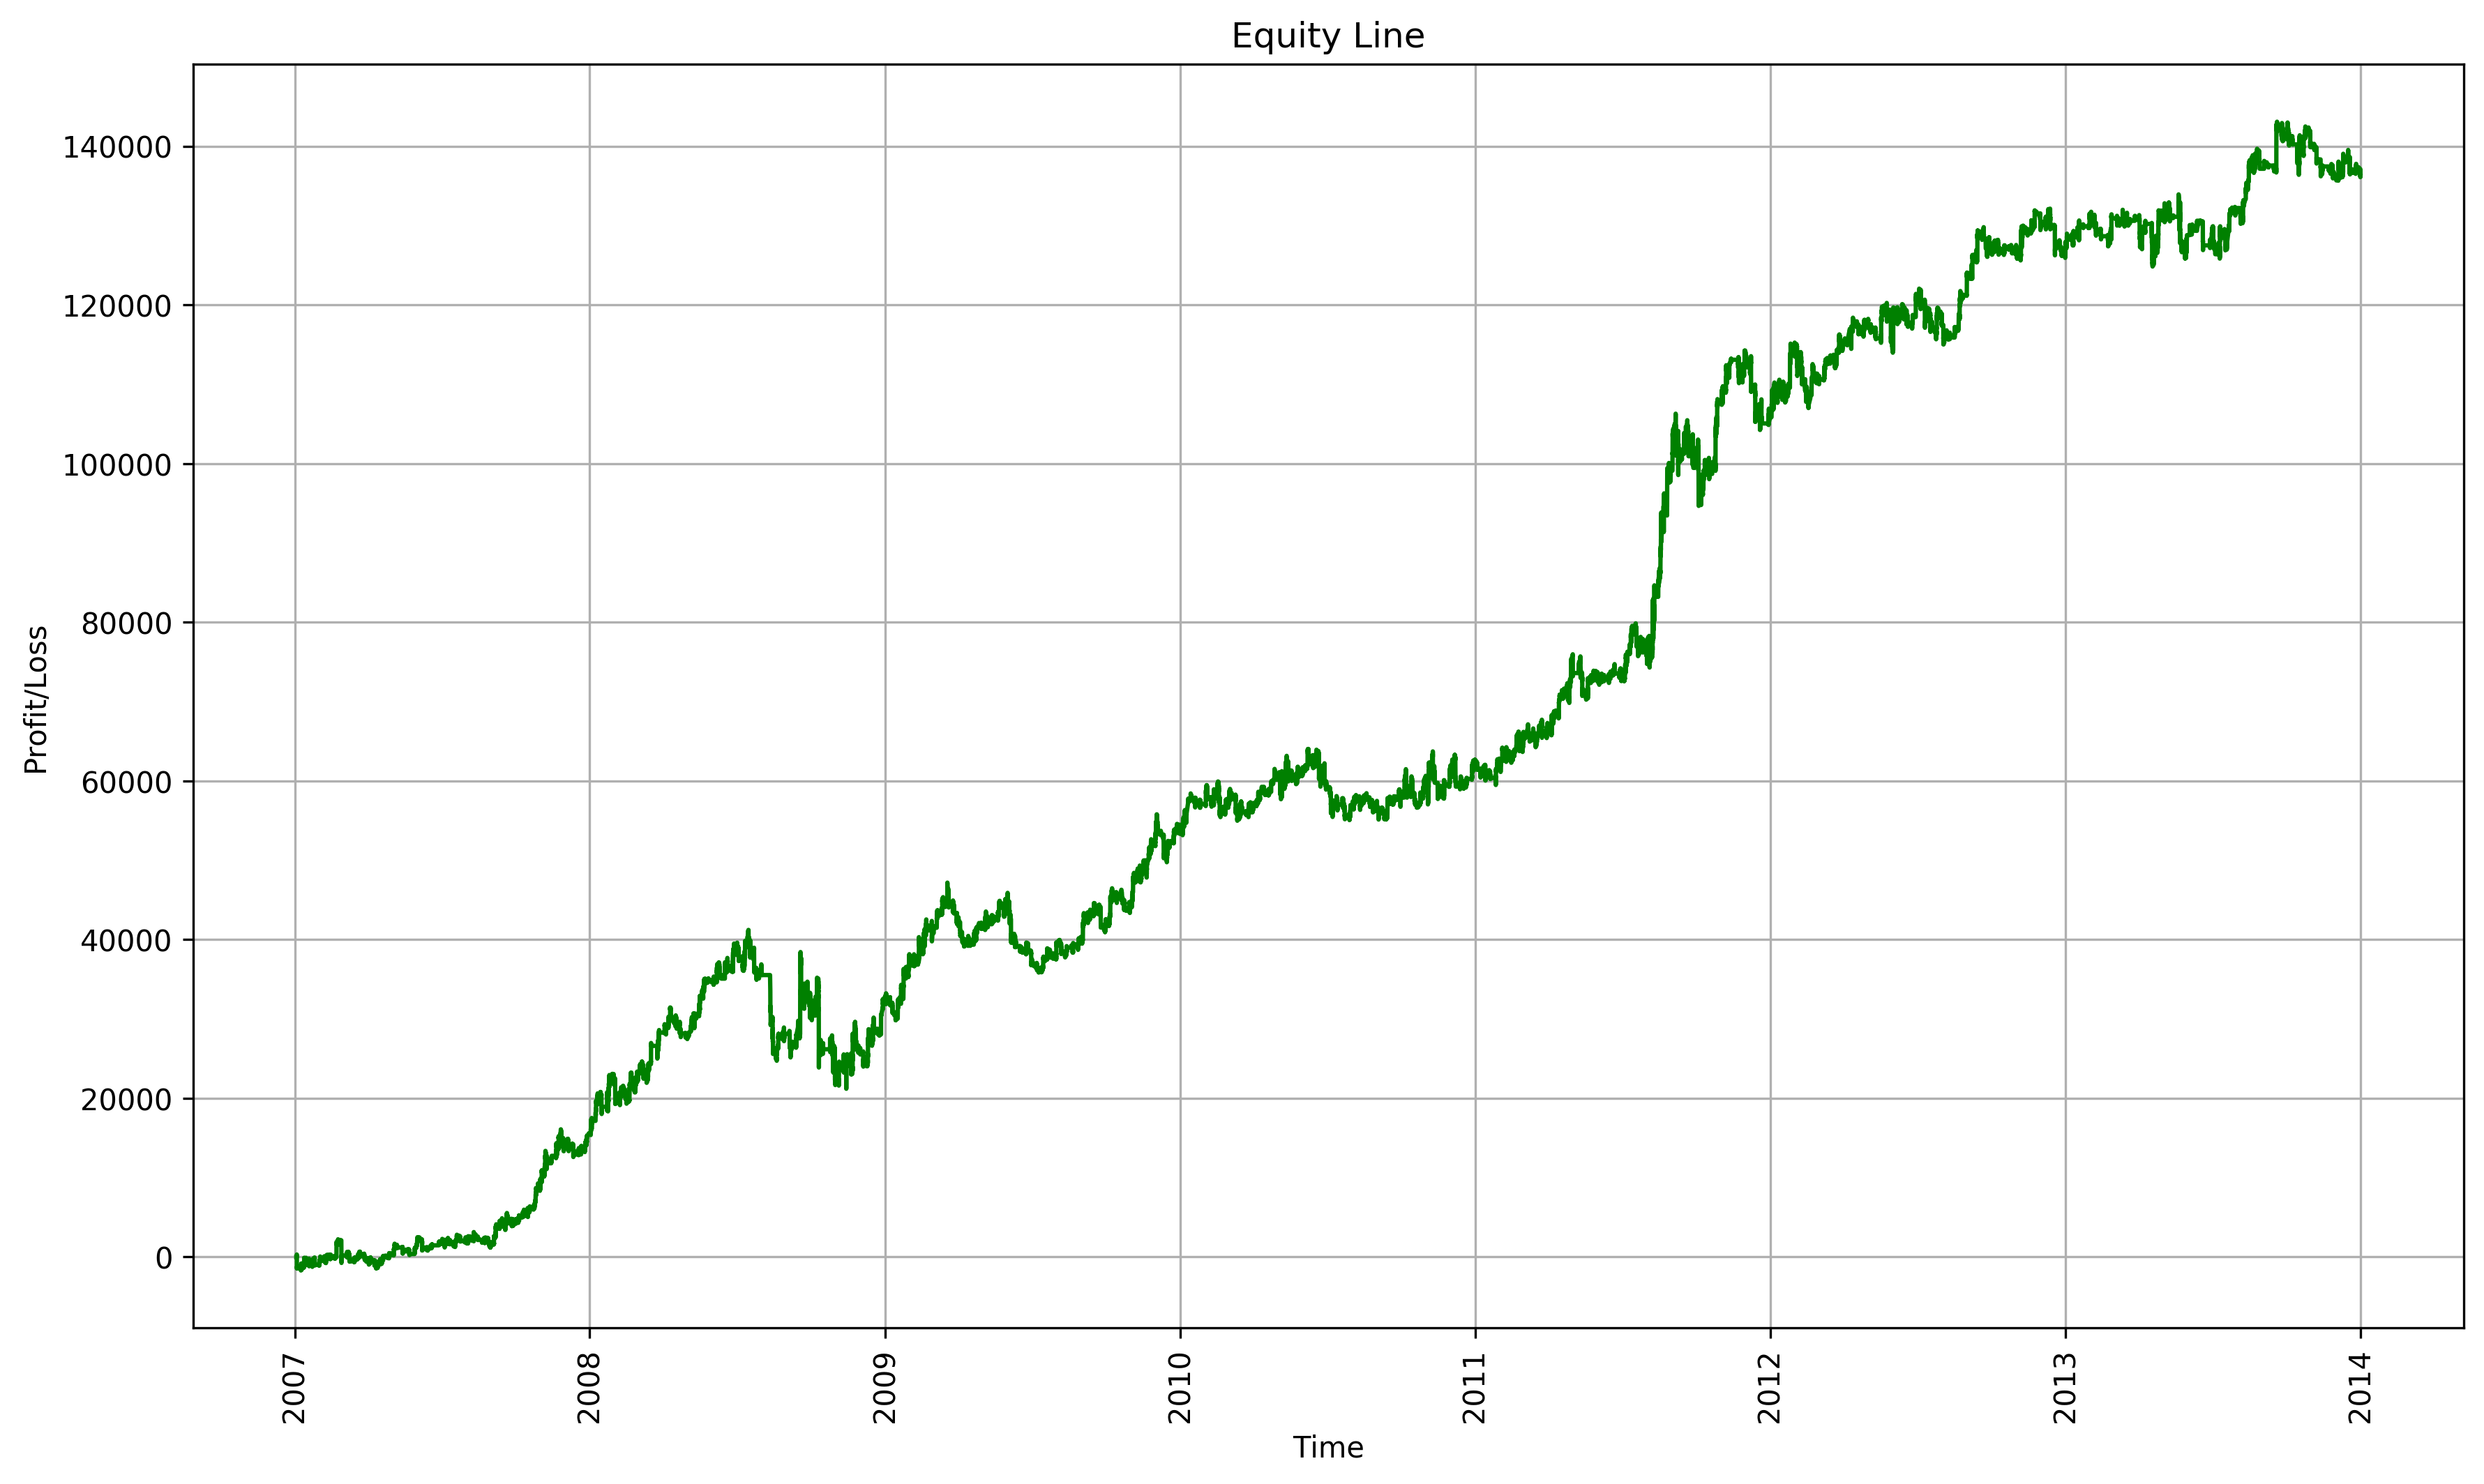

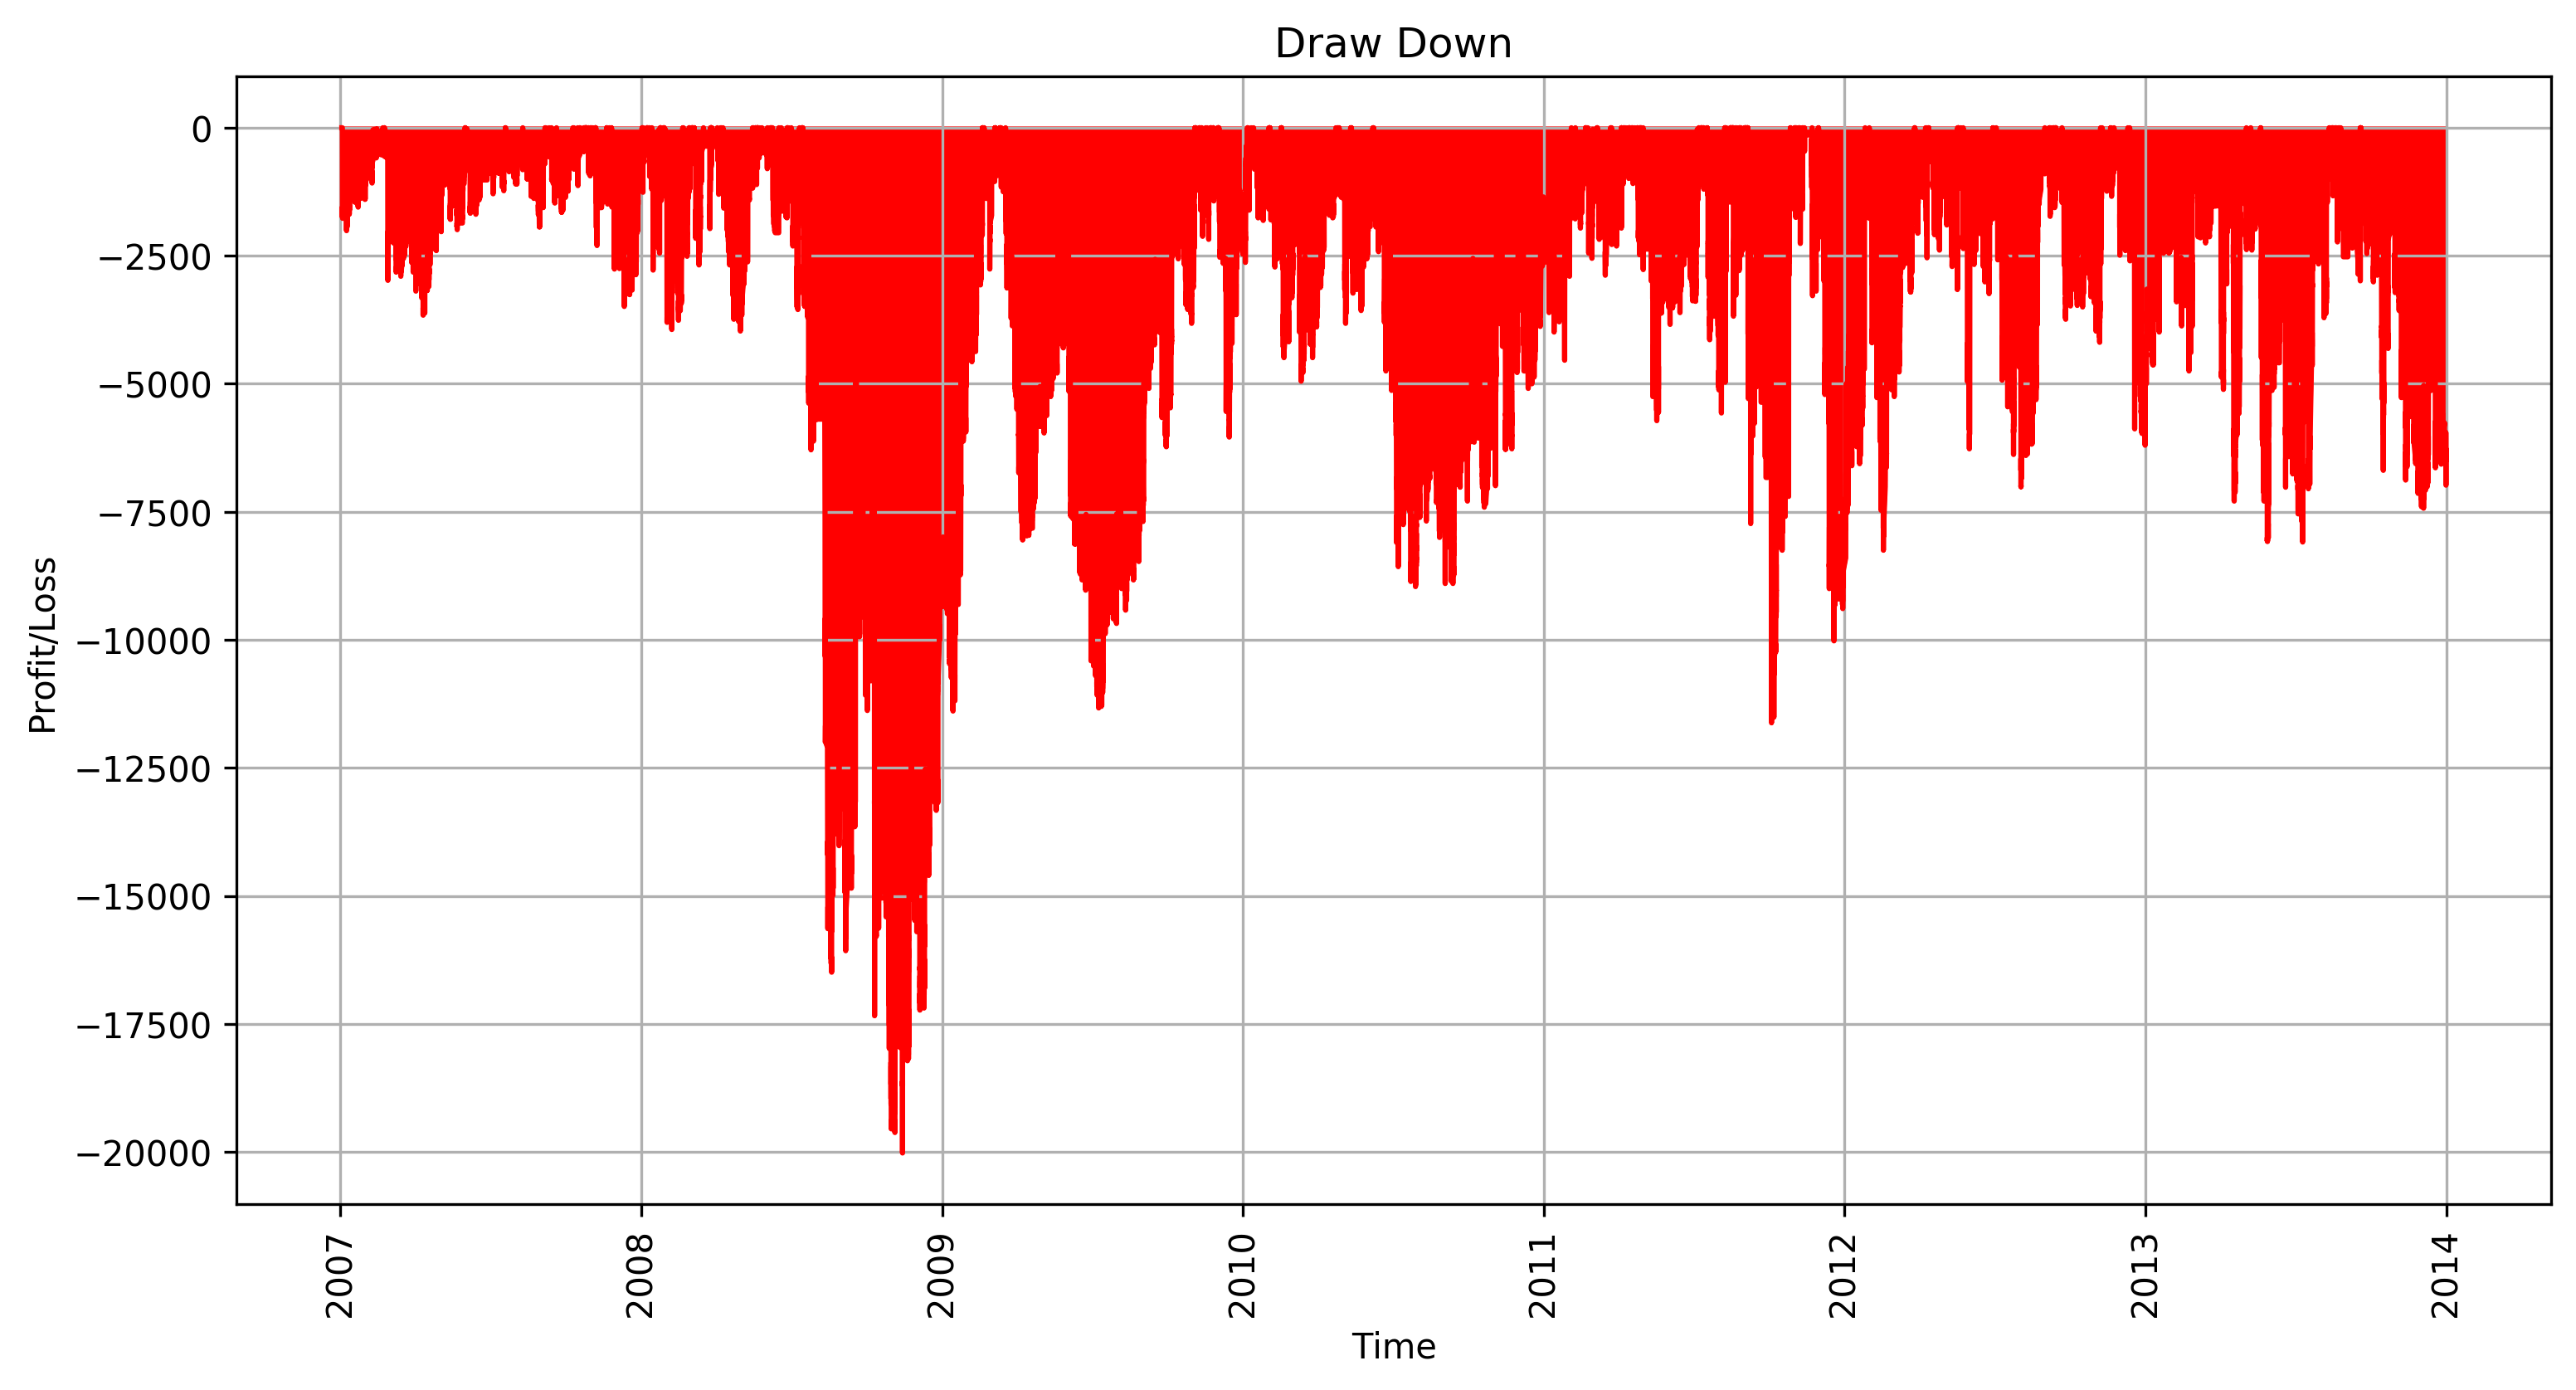

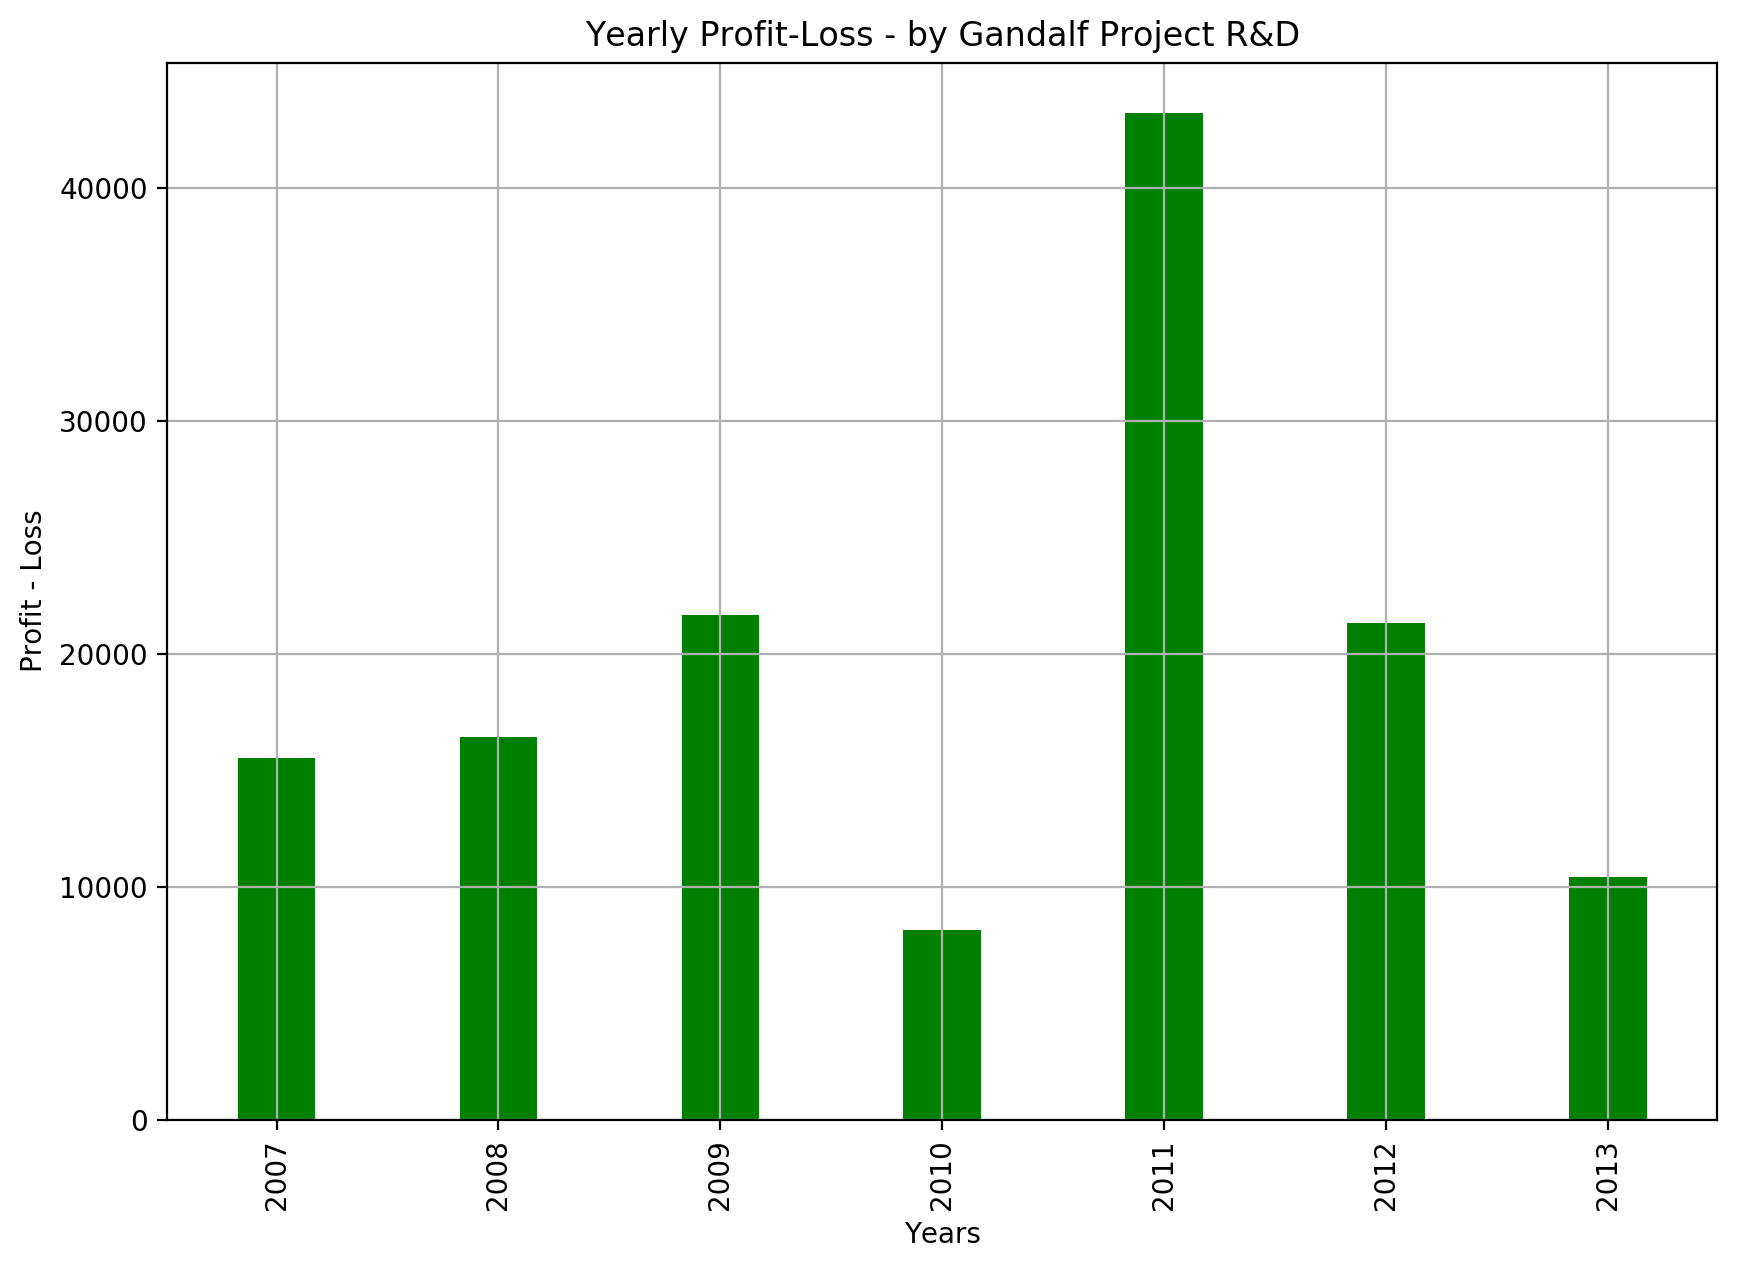

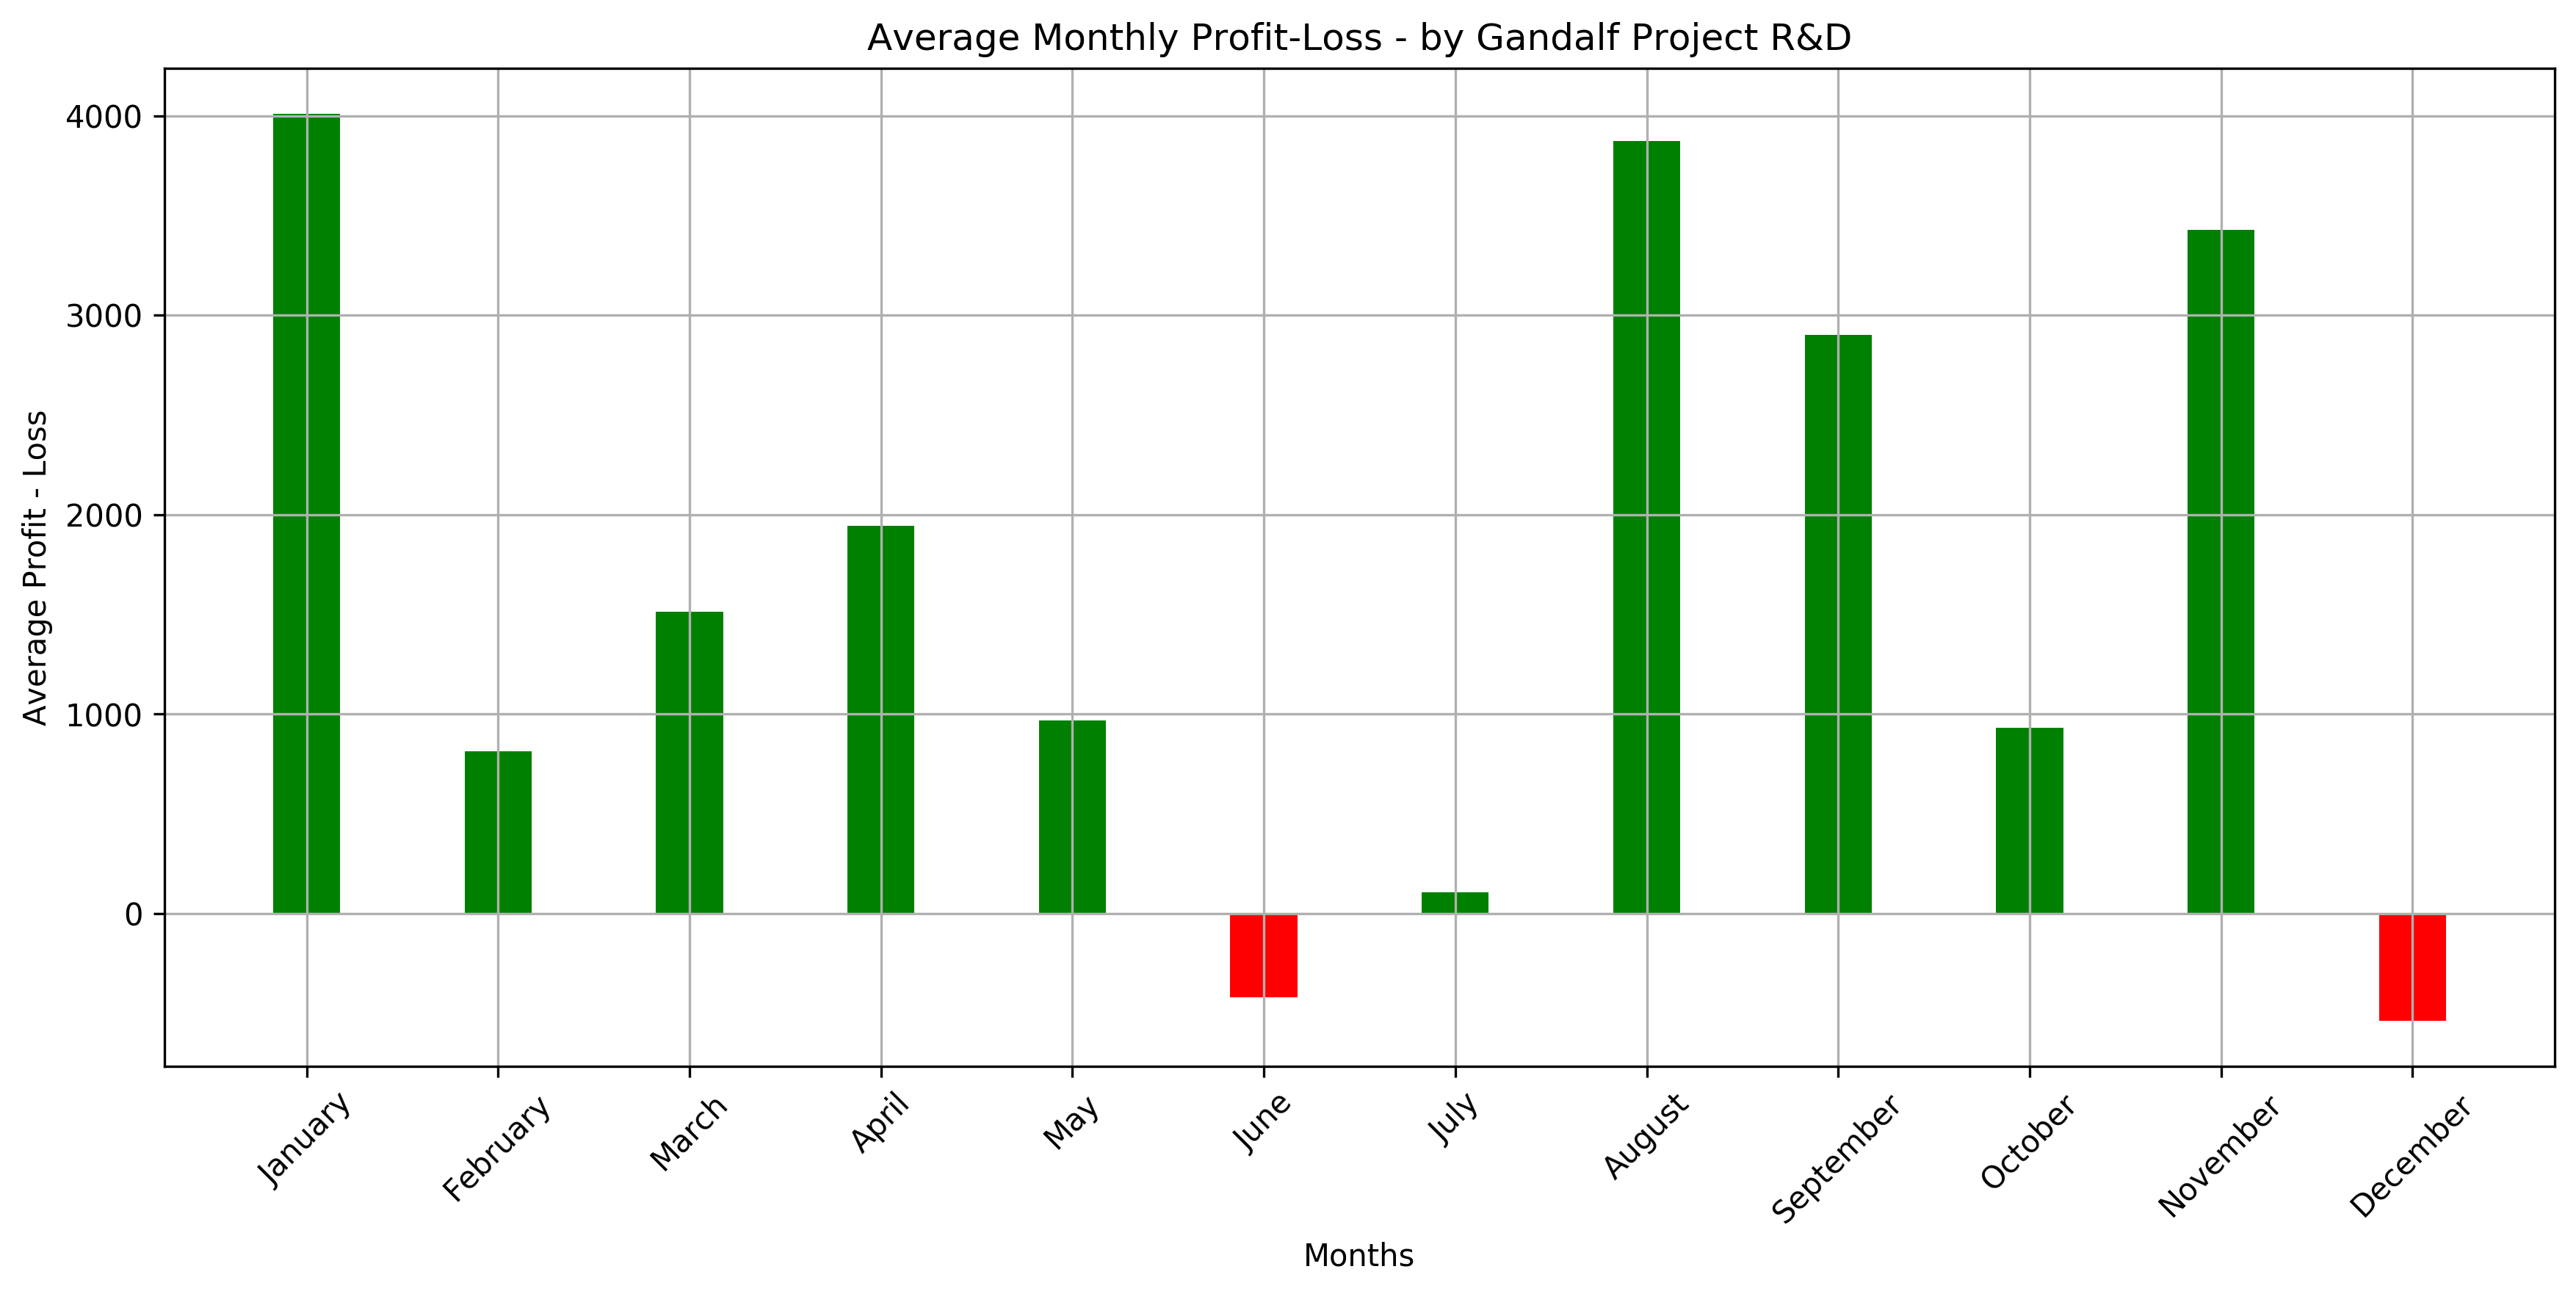

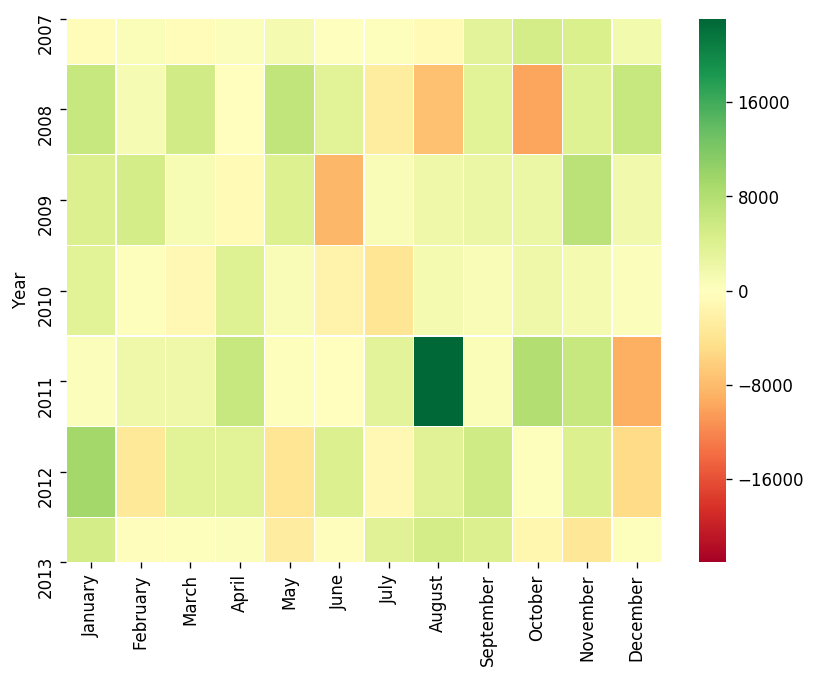

In [12]:
dataset_IS["hhv92"] = dataset_IS.high.rolling(92).max()
dataset_IS["llv92"] = dataset_IS.low.rolling(92).min()
dataset_IS.dropna(inplace=True)

COSTS = 0
INSTRUMENT = 2 # 1: equity/forex, 2: future
BIGPOINTVALUE = 100
TICK = 0.1
OPERATION_MONEY = 10000
DIRECTION = "long"
ORDER_TYPE = "stop"

enter_rules_IS = 1
enter_level_IS = dataset_IS.hhv92.shift(1)
exit_rules_IS = dataset_IS.hour == 22

trading_system_IS = apply_trading_system(dataset_IS, BIGPOINTVALUE, TICK, DIRECTION, ORDER_TYPE, 
                                         enter_level_IS, enter_rules_IS, exit_rules_IS)

operations_IS = trading_system_IS.operations.dropna()

if operations_IS.count() > 0:
    performance_report(trading_system_IS, operations_IS,
                       trading_system_IS.closed_equity, trading_system_IS.open_equity)
else: 
    print("Nessuna operazione registrata!")

Percentiles of Trades Distribution in In Sample
count    1129.000000
mean      121.142604
std      1156.716367
min     -7010.000000
10%     -1060.000000
20%      -560.000000
30%      -270.000000
40%       -70.000000
50%       110.000000
60%       270.000000
70%       520.000000
80%       840.000000
90%      1360.000000
max      8780.000000
Name: operations, dtype: float64


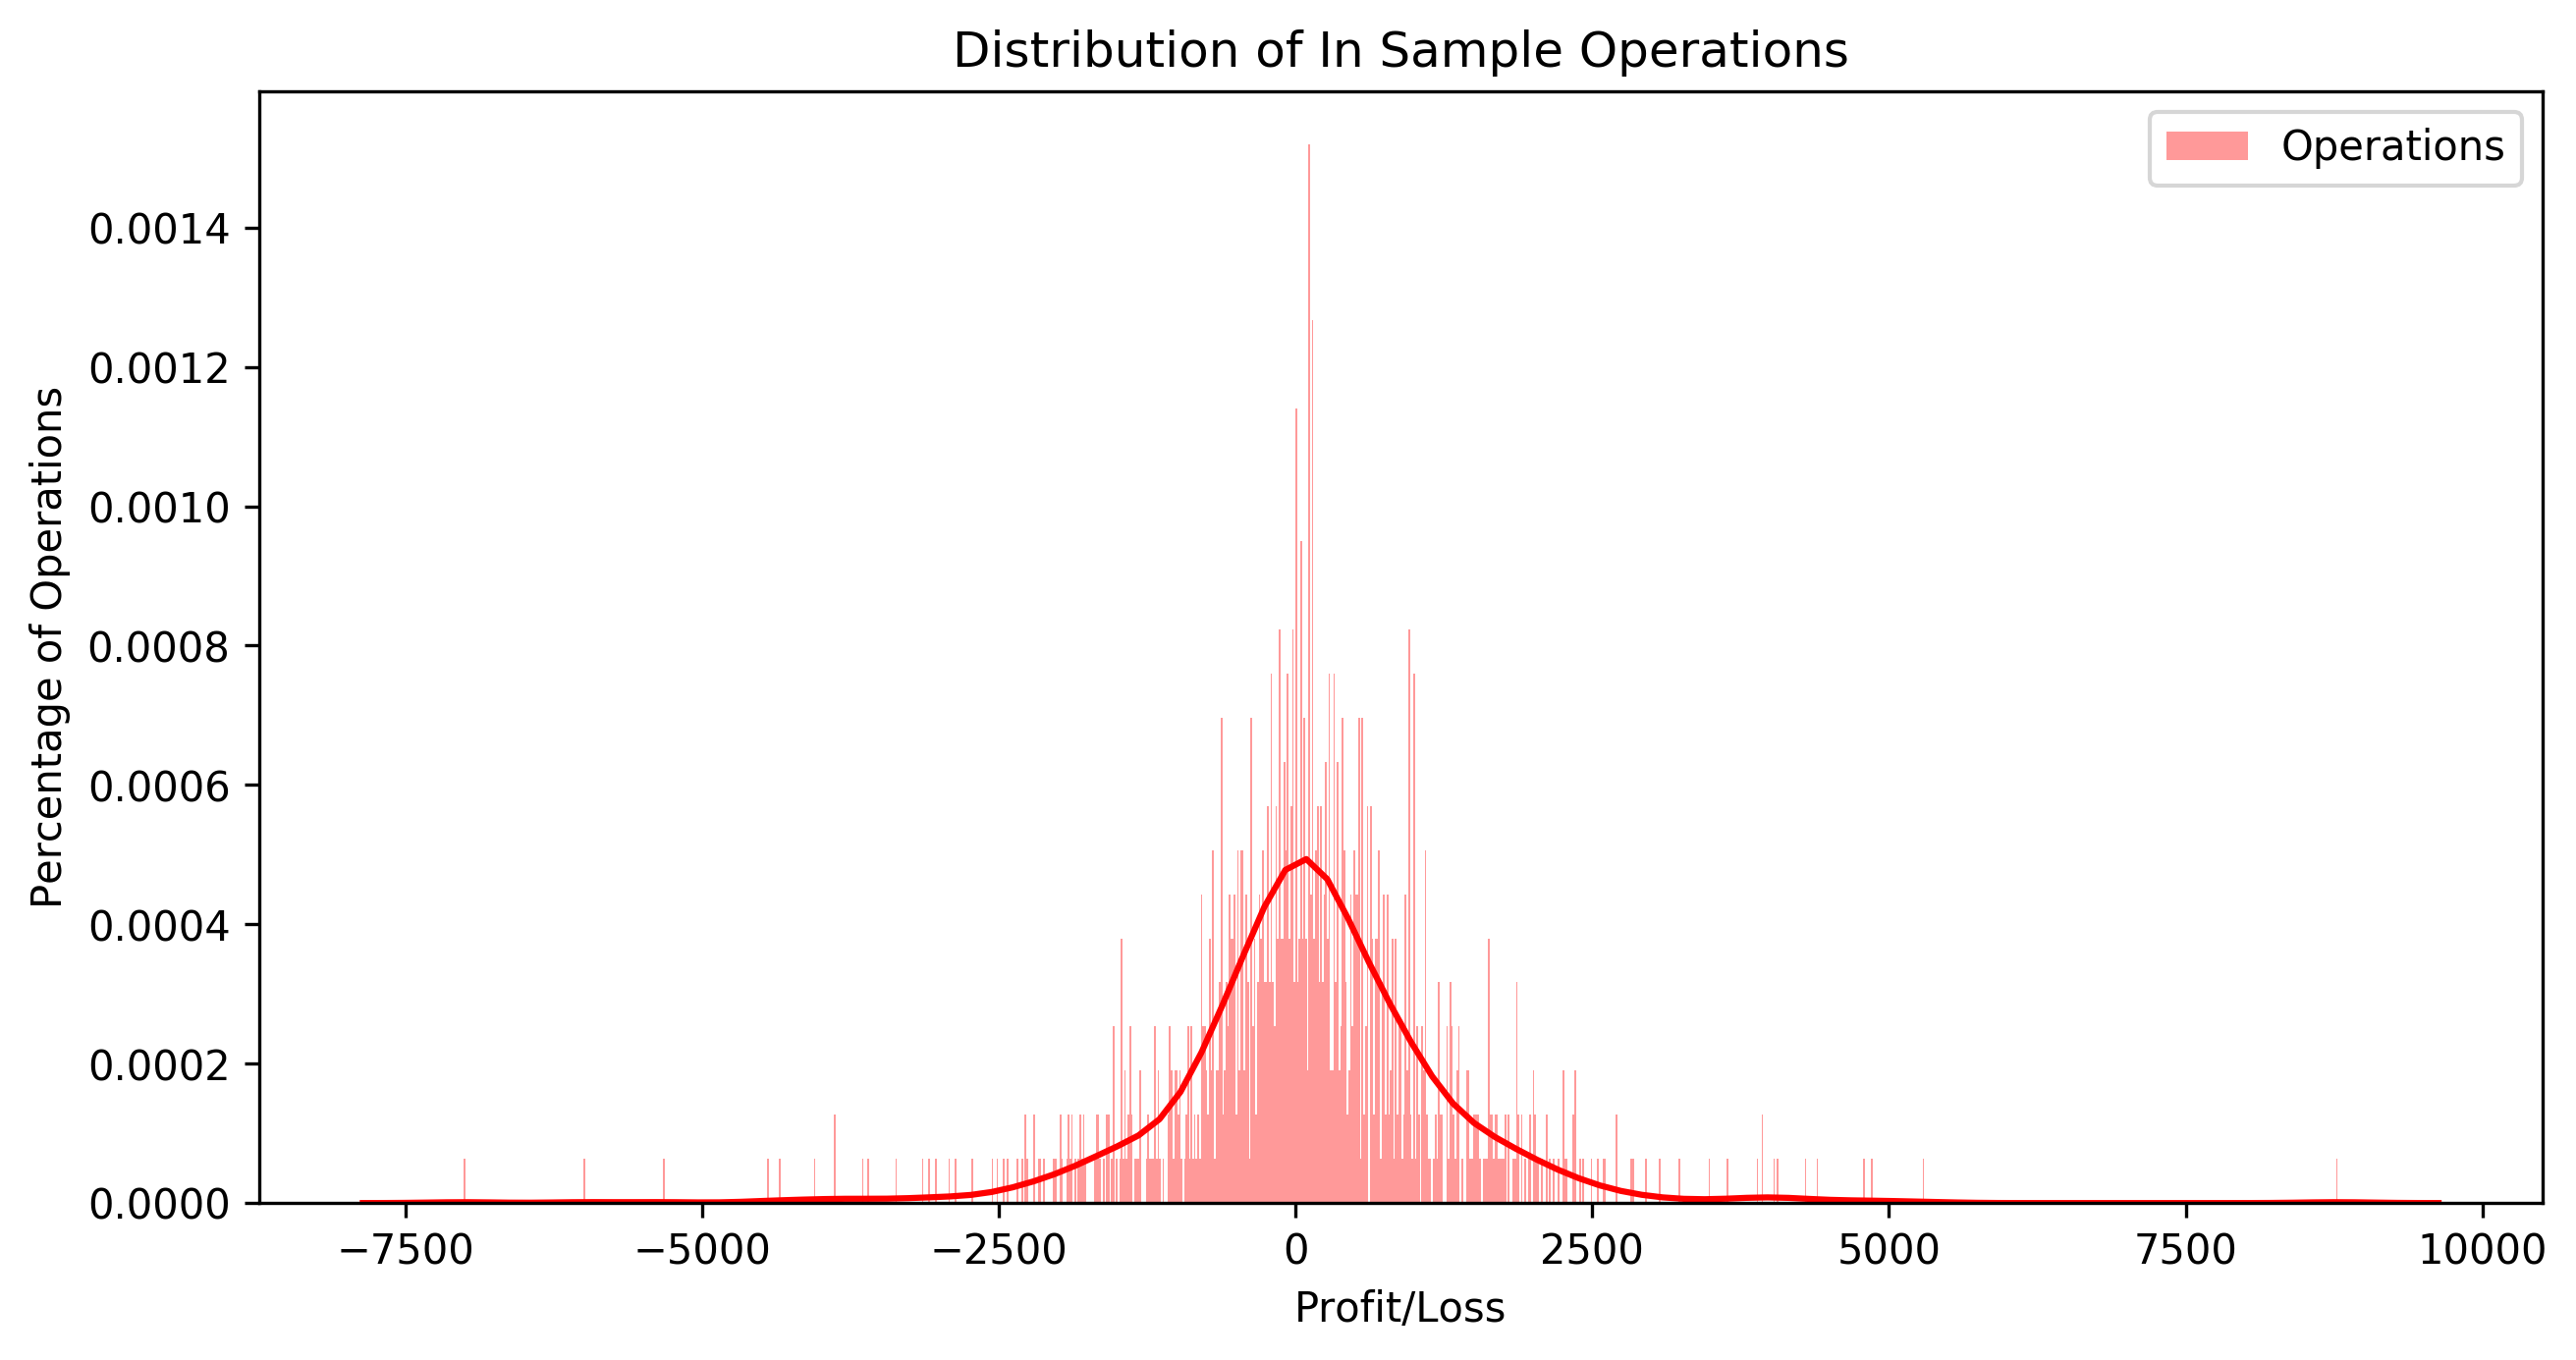

In [13]:
print("Percentiles of Trades Distribution in In Sample")
print(operations_IS.dropna().describe(percentiles = [0.10,0.20,0.30,0.40,0.50,0.60,0.70,0.80,0.90]))

plt.figure(figsize = (10,5), dpi = 300)
sns.distplot(operations_IS.dropna(), bins = trading_system_IS.operations.count(), 
             color = "red", label = "Operations")
plt.title("Distribution of In Sample Operations")
plt.xlabel("Profit/Loss")
plt.ylabel("Percentage of Operations")
plt.legend()
plt.show()

# Out of Sample

Performance Report - by Gandalf Project R&D

Profit:                   60990.0
Operations:               860
Average Trade:            70.92

Profit Factor:            1.27
Gross Profit:             286810.0
Gross Loss:               -225820.0

Percent Winning Trades:   51.51
Percent Losing Trades:    48.49
Reward Risk Ratio:        1.2

Max Gain:                 3980.0  in date  2019-08-25 22:00:00
Average Gain:             647.43
Max Loss:                 -3740.0  in date  2016-11-09 22:00:00
Average Loss:             -548.11

Avg Open Draw Down:       -4170.46
Max Open Draw Down:       -12290.0

Avg Closed Draw Down:     -3875.34
Max Closed Draw Down:     -11100.0

Avg Delay Between Peaks:  446.88
Max Delay Between Peaks:  28115


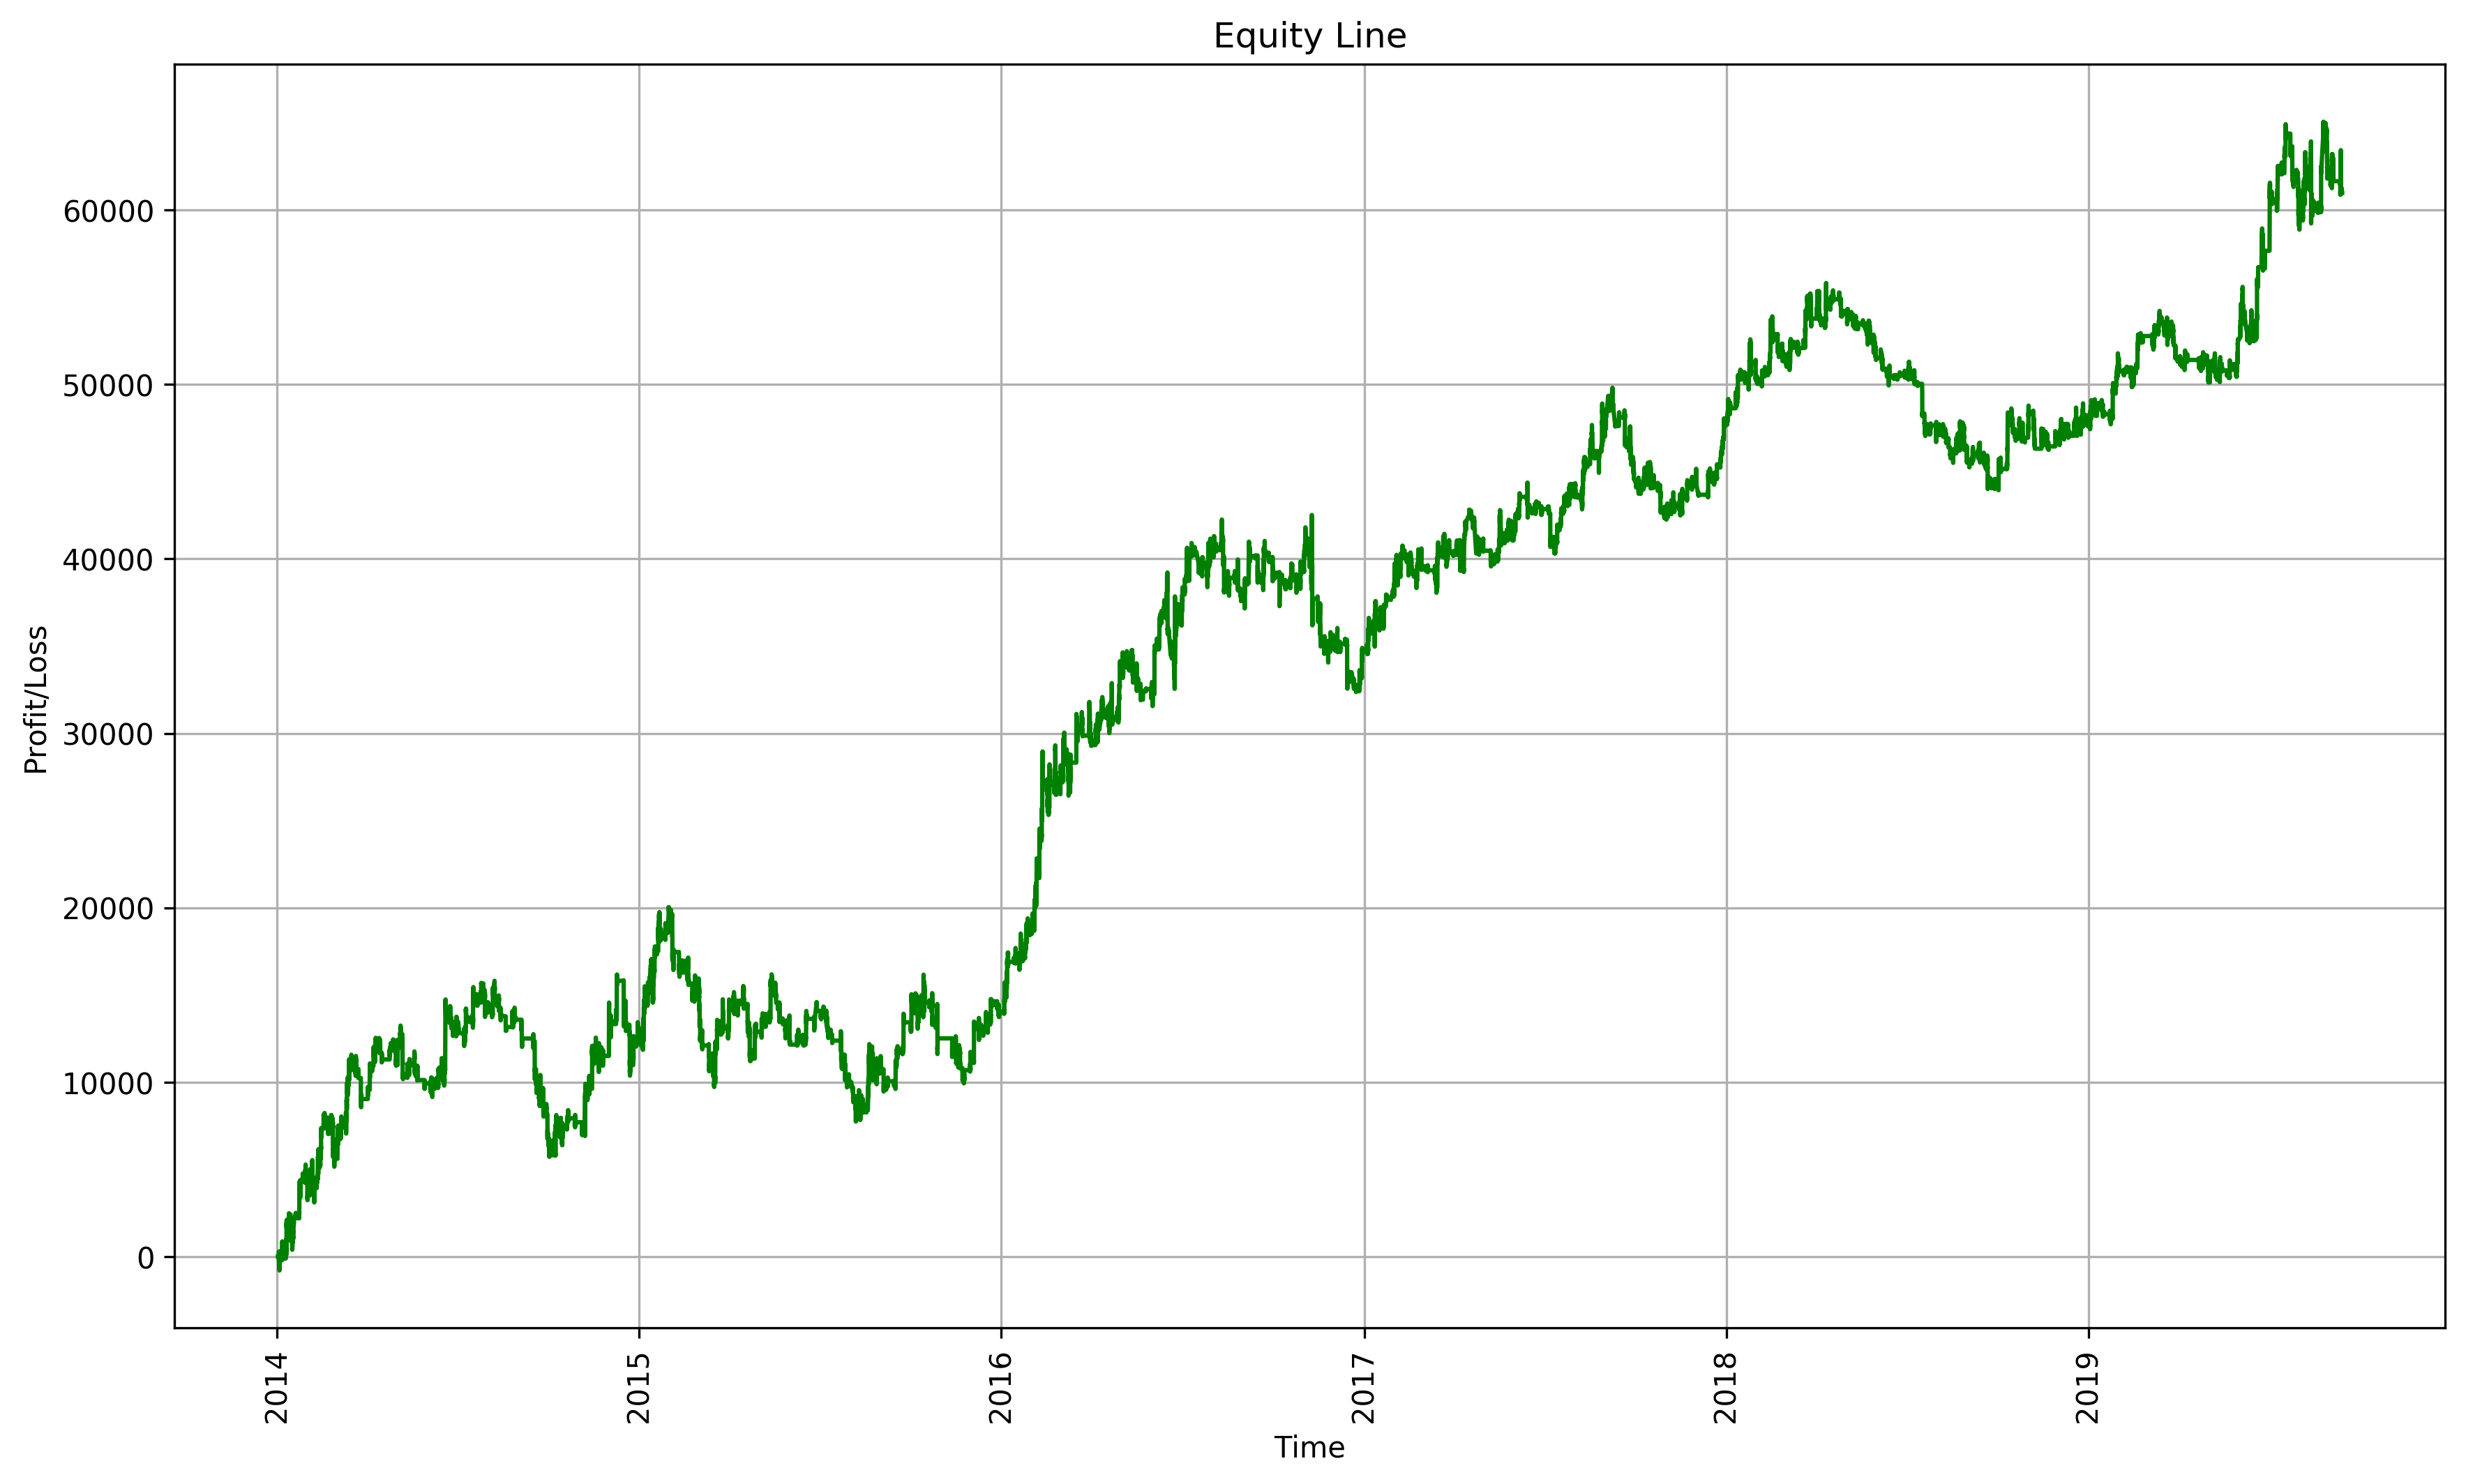

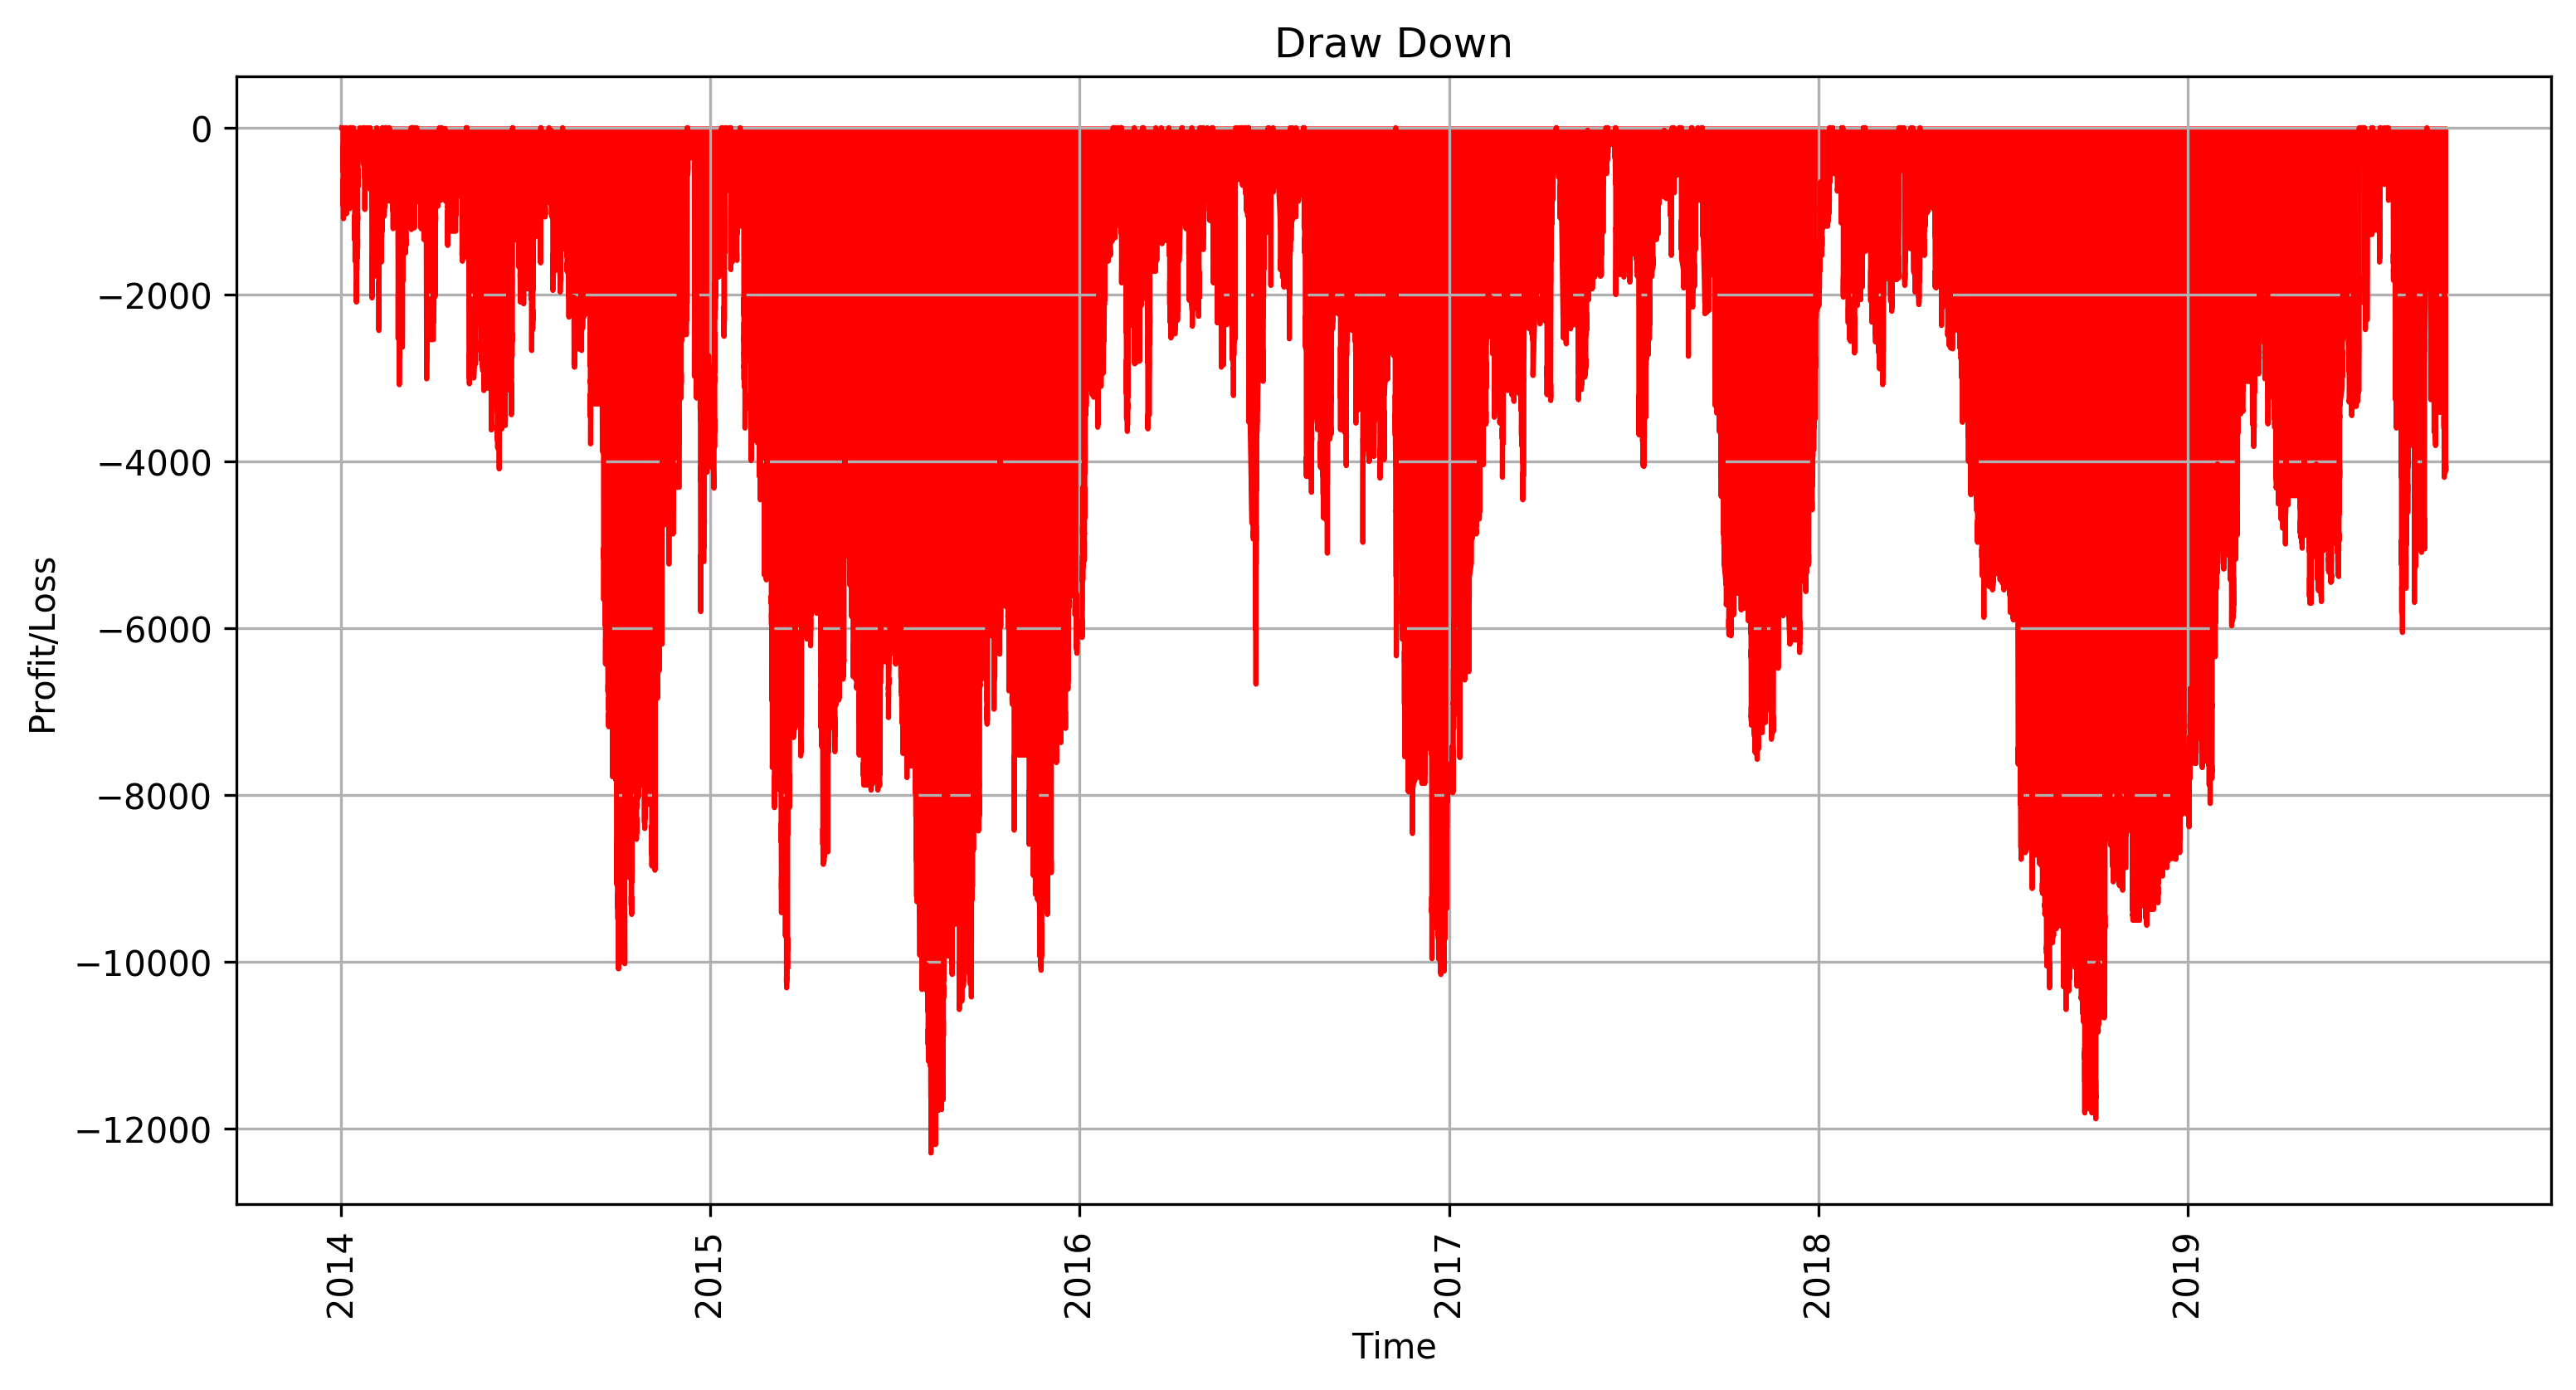

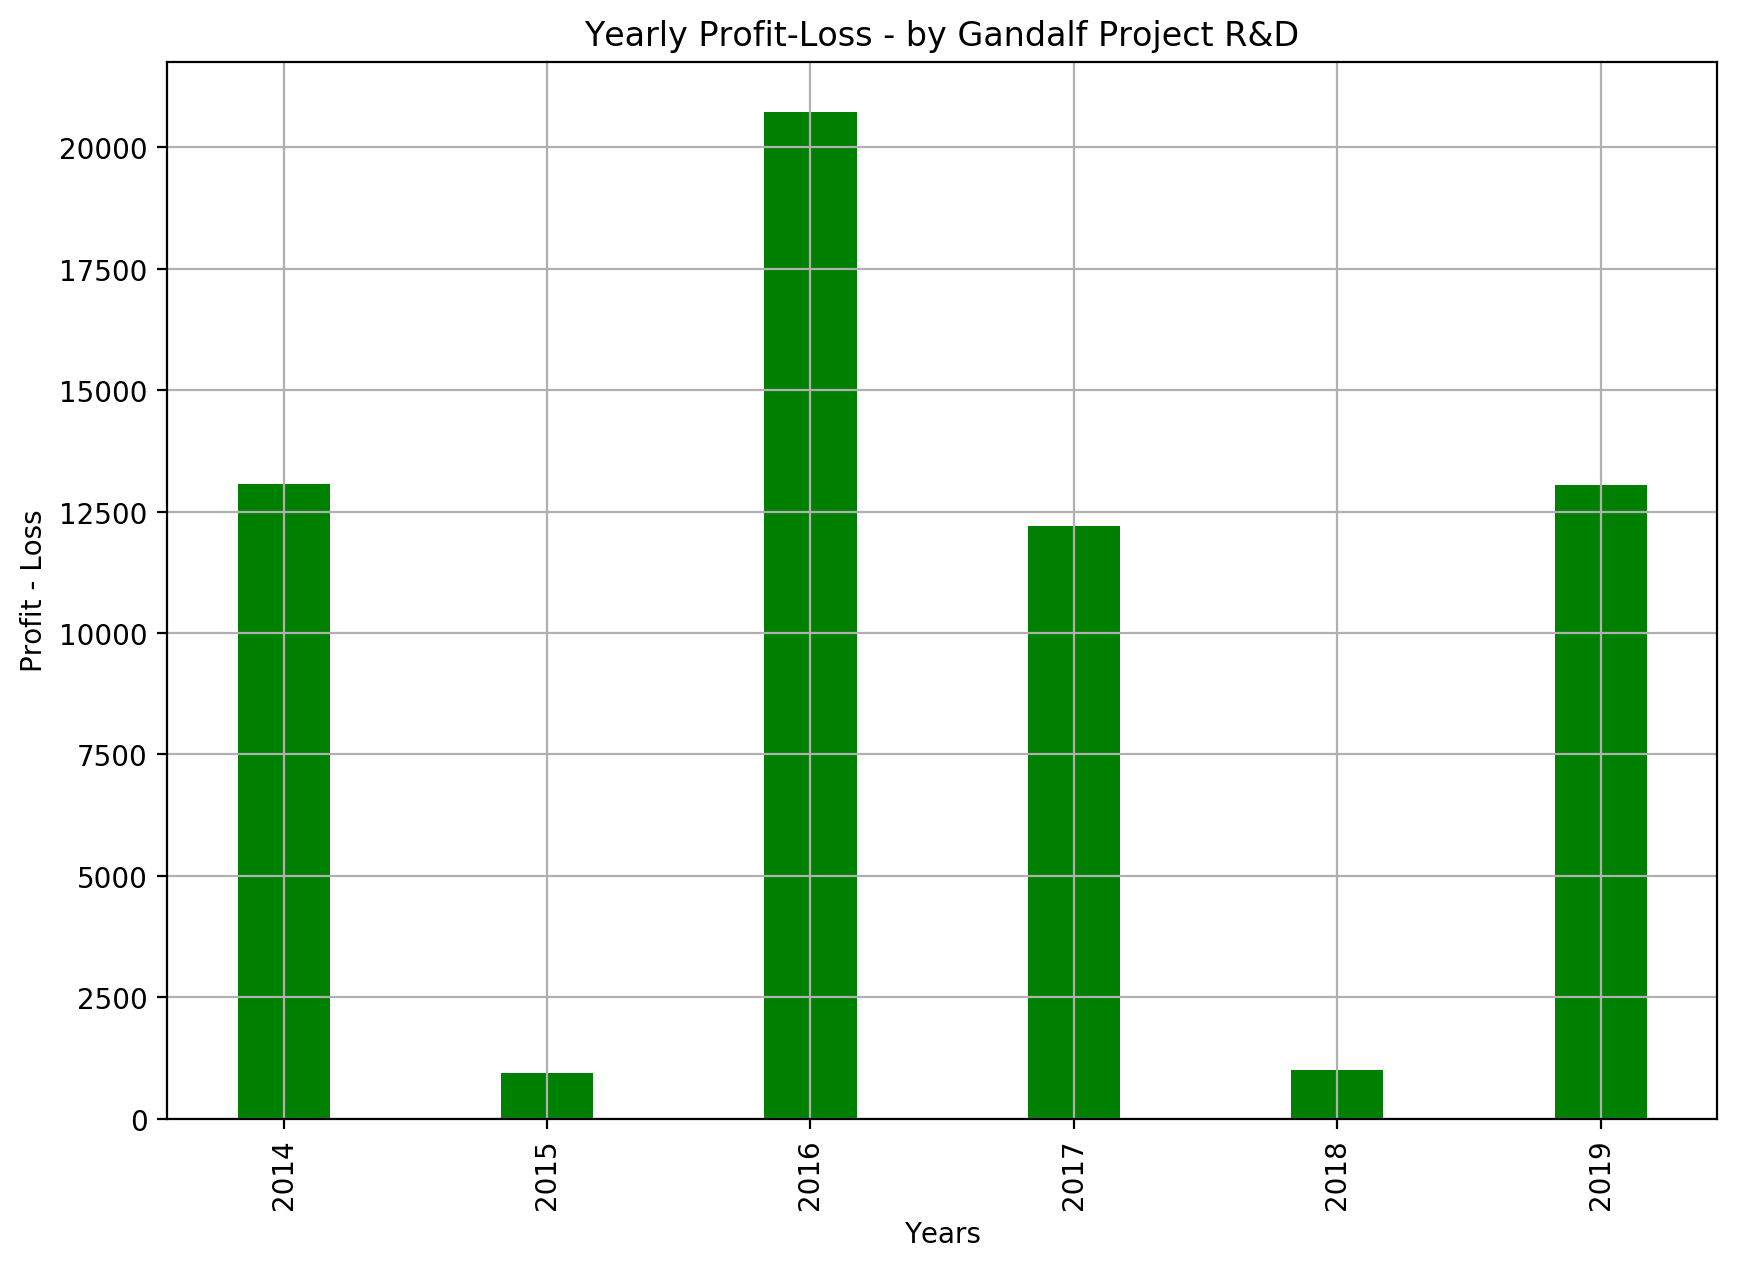

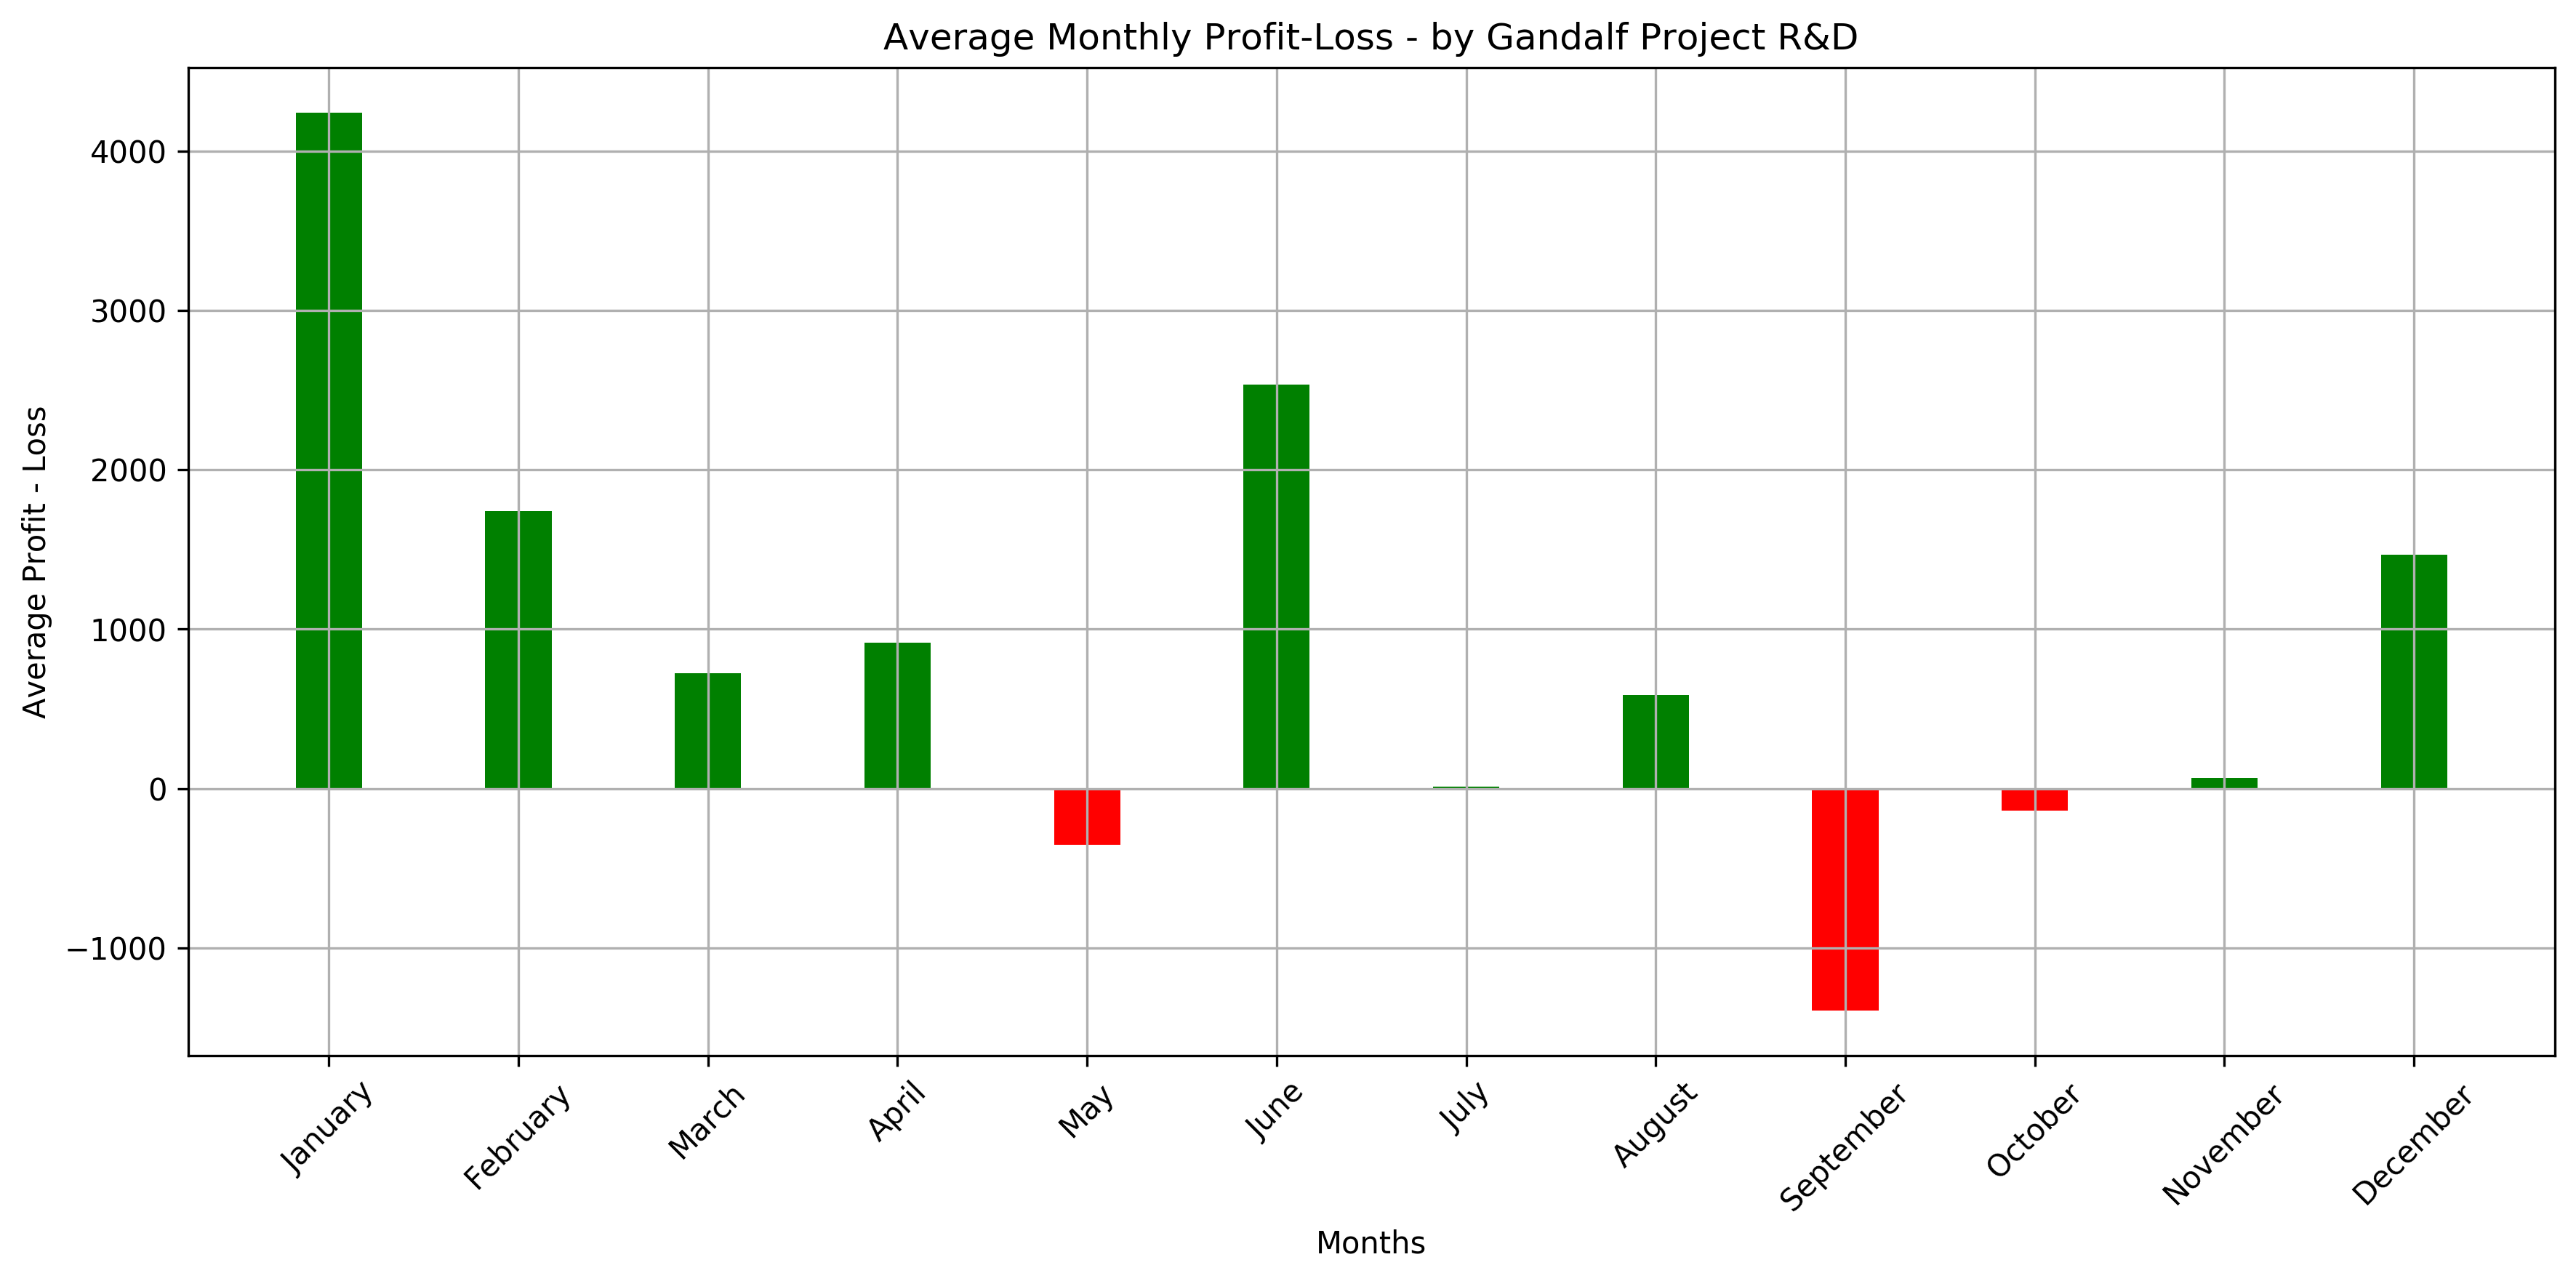

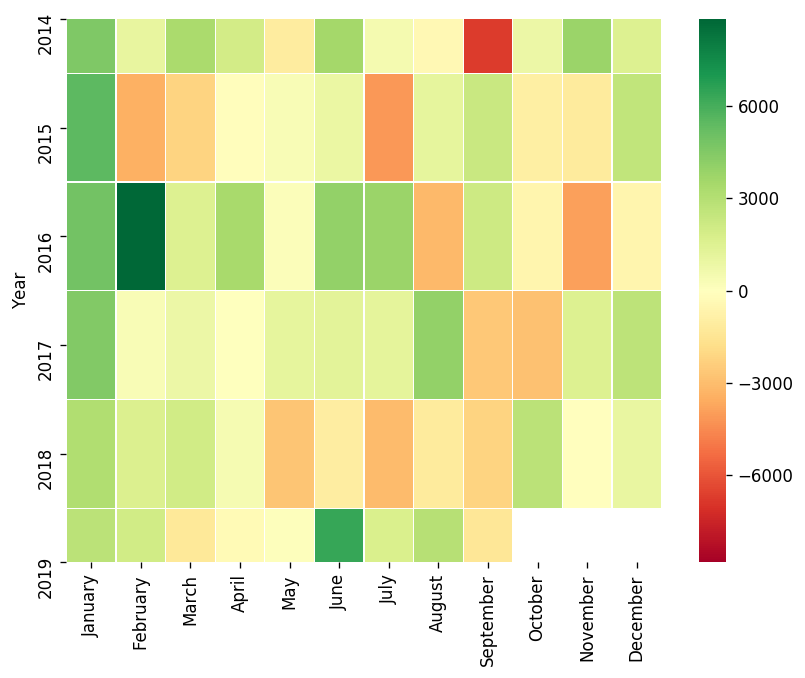

In [19]:
dataset_OOS["hhv92"] = dataset_OOS.high.rolling(92).max()
dataset_OOS["llv92"] = dataset_OOS.low.rolling(92).min()
dataset.dropna(inplace=True)

COSTS = 0
INSTRUMENT = 2 # 1: equity/forex, 2: future
BIGPOINTVALUE = 100
TICK = 0.1
OPERATION_MONEY = 10000
DIRECTION = "long"
ORDER_TYPE = "stop"

enter_rules_OOS = 1
enter_level_OOS = dataset_OOS.hhv92.shift(1)
exit_rules_OOS = dataset_OOS.hour == 22

trading_system_OOS = apply_trading_system(dataset_OOS, BIGPOINTVALUE, TICK, DIRECTION, ORDER_TYPE, 
                                          enter_level_OOS, enter_rules_OOS, exit_rules_OOS)

operations_OOS = trading_system_OOS.operations.dropna()

if operations_OOS.count() > 0:
    performance_report(trading_system_OOS, operations_OOS,
                       trading_system_OOS.closed_equity,trading_system_OOS.open_equity)
else: 
    print("Nessuna operazione registrata!")

Percentiles of Trades Distribution in Out of Sample
count     860.000000
mean       70.918605
std       822.046039
min     -3740.000000
10%      -810.000000
20%      -472.000000
30%      -280.000000
40%      -150.000000
50%        30.000000
60%       170.000000
70%       380.000000
80%       650.000000
90%      1021.000000
max      3980.000000
Name: operations, dtype: float64


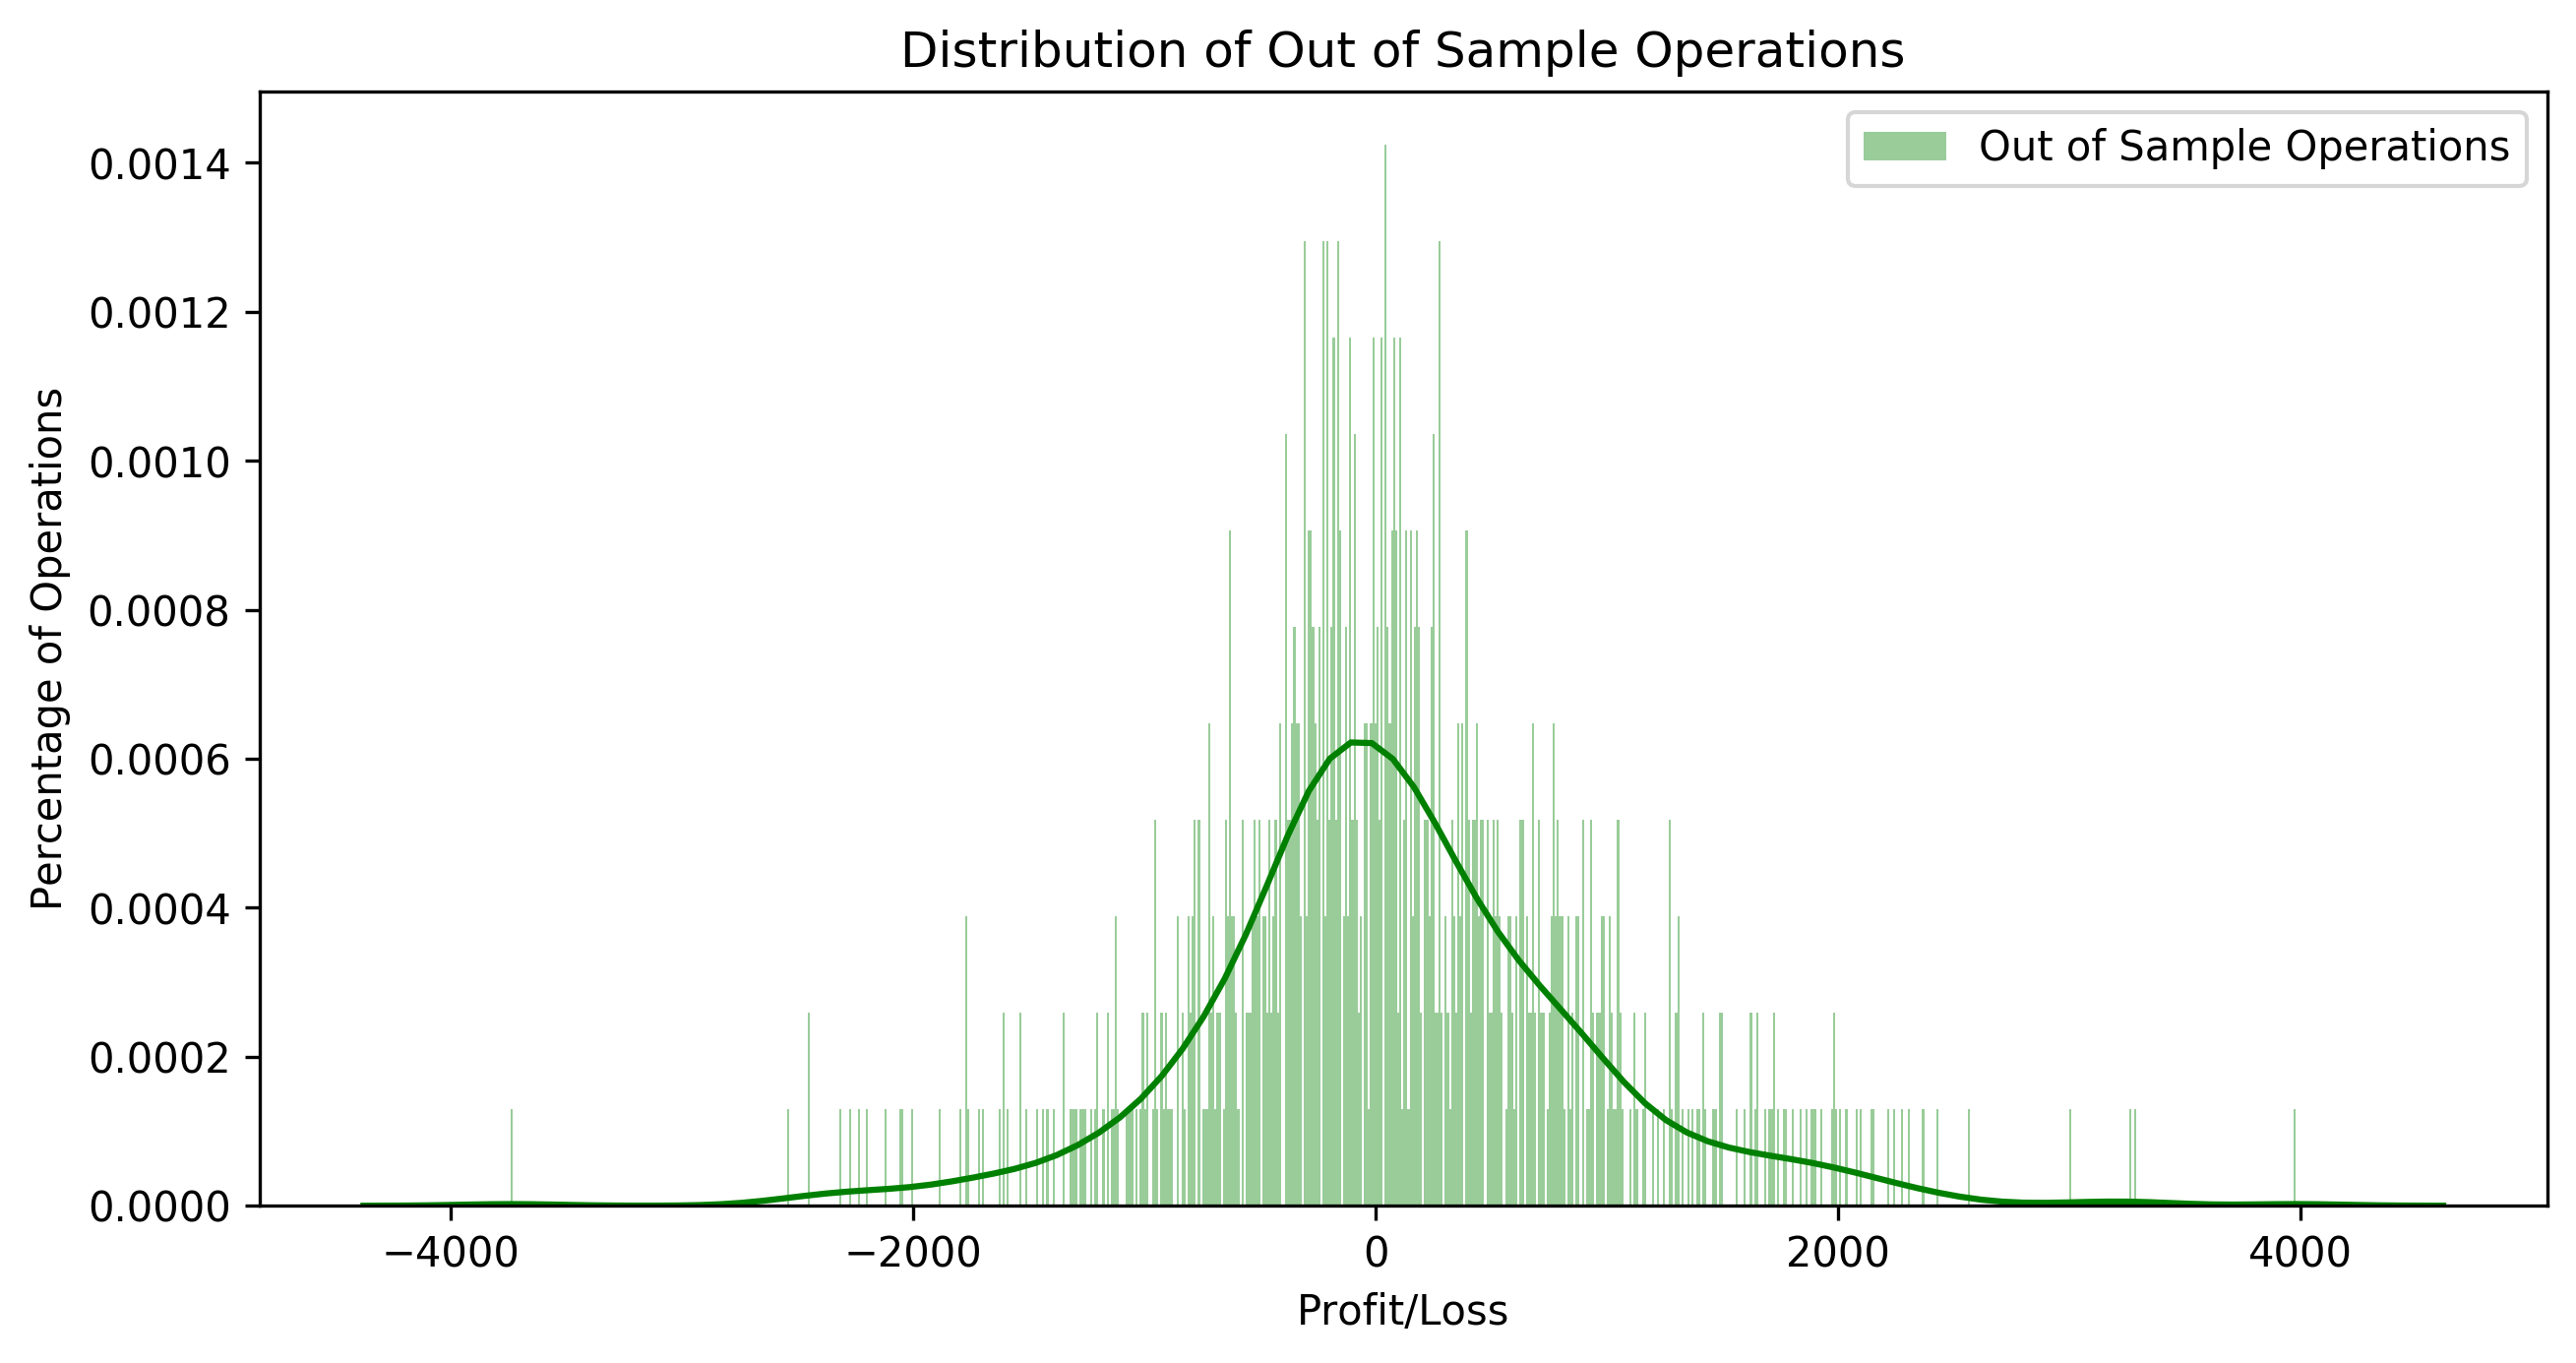

In [20]:
print("Percentiles of Trades Distribution in Out of Sample")
print(operations_OOS.dropna().describe(percentiles = [0.10,0.20,0.30,0.40,0.50,0.60,0.70,0.80,0.90]))

plt.figure(figsize = (10,5),dpi = 300)
sns.distplot(operations_OOS.dropna(), bins = trading_system_OOS.operations.count(), 
             color = "green", label = "Out of Sample Operations")
plt.title("Distribution of Out of Sample Operations")
plt.xlabel("Profit/Loss")
plt.ylabel("Percentage of Operations")
plt.legend()
plt.show()

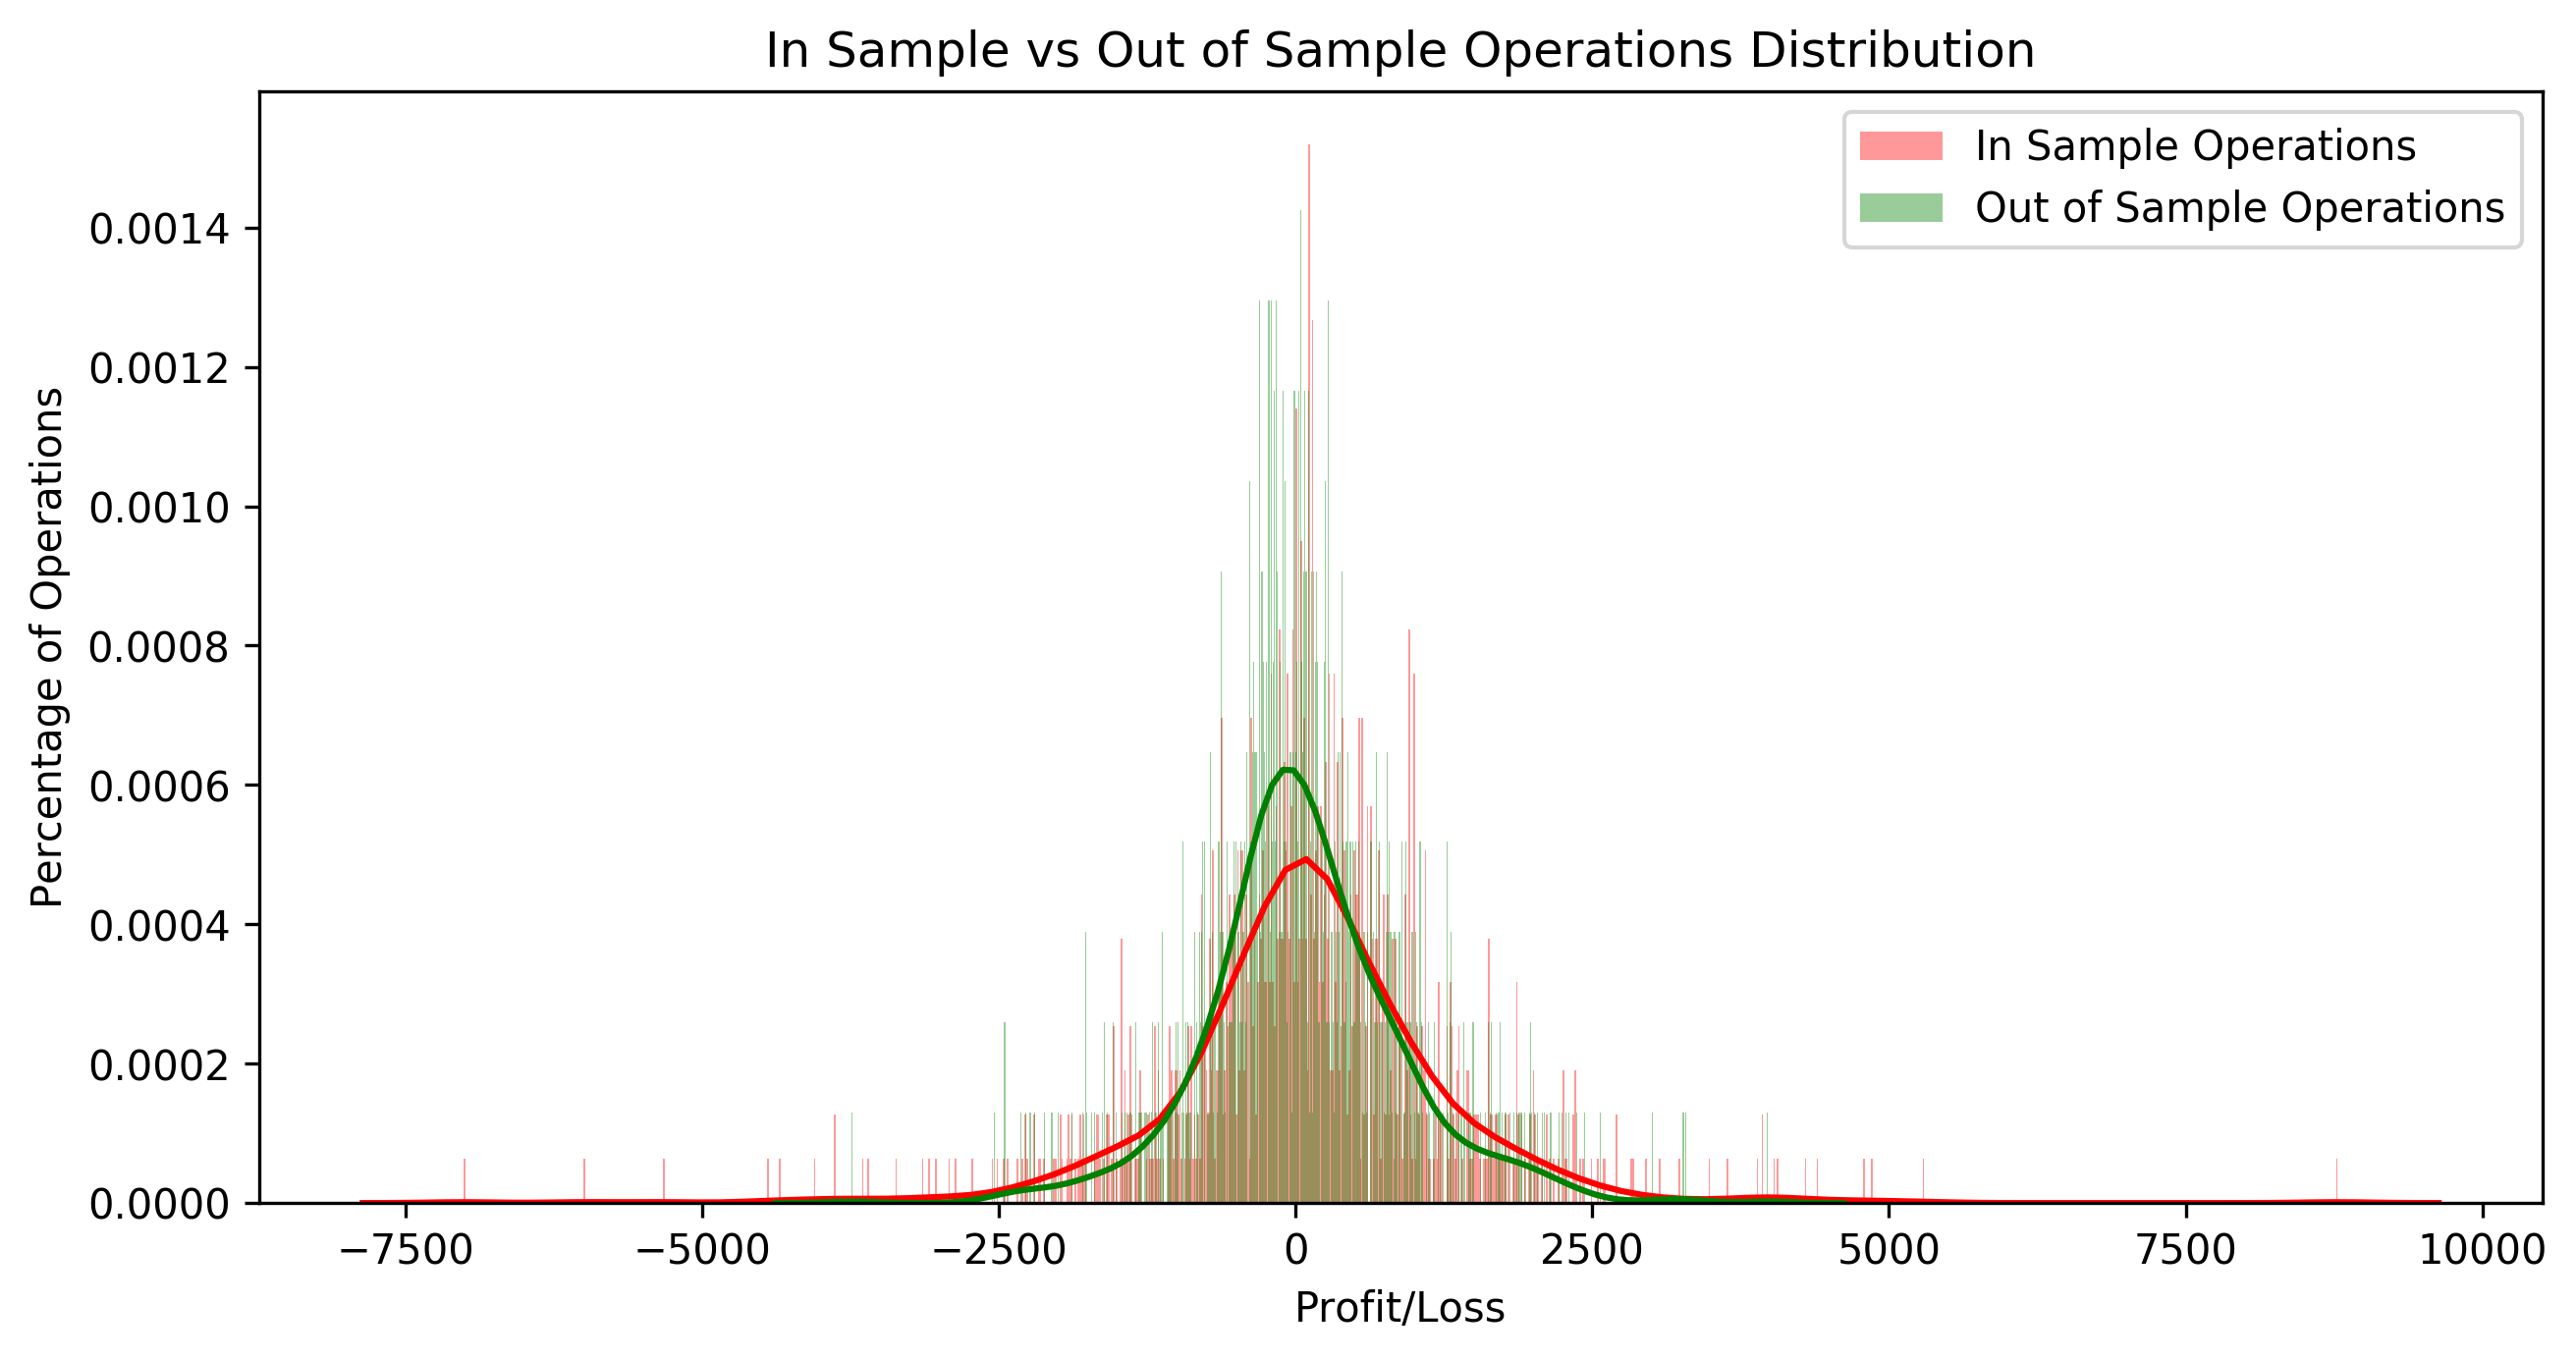

In [25]:
plt.figure(figsize = (10,5),dpi = 300)
sns.distplot(operations_IS.dropna(), bins = int(trading_system_IS.operations.count()), 
             color = "red", label = "In Sample Operations")
sns.distplot(operations_OOS.dropna(), bins = int(trading_system_OOS.operations.count()), 
             color = "green", label = "Out of Sample Operations")
plt.title("In Sample vs Out of Sample Operations Distribution")
plt.xlabel("Profit/Loss")
plt.ylabel("Percentage of Operations")
plt.legend()
plt.show()

In [67]:
"""
 Gandalf Persistence Distribution Index (GPDI)
 Versione base: dividiamo i percentili in 10 blocchi e per ciascuno confrontiamo il valore numerico
 in In Sample ed in Out of Sample
"""
step = 0.1
values = np.arange(0.0, 1.0 + step, step)
print(values)
print("")

IS = 0
OoS = 0
for i in values:
    if operations_IS.quantile(i) <= operations_OOS.quantile(i):
        OoS += 1
    else:
        IS += 1
    print(round(i,2), round(operations_IS.quantile(i),2), round(operations_OOS.quantile(i),2), IS, OoS)
    
print("")
print("Gandalf Persistence Distribution Index (GPDI):", round(OoS/len(values)*100,2), "%")

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]

0.0 -7010.0 -3740.0 0 1
0.1 -1060.0 -810.0 0 2
0.2 -560.0 -472.0 0 3
0.3 -270.0 -280.0 1 3
0.4 -70.0 -150.0 2 3
0.5 110.0 30.0 3 3
0.6 270.0 170.0 4 3
0.7 520.0 380.0 5 3
0.8 840.0 650.0 6 3
0.9 1360.0 1021.0 7 3
1.0 8780.0 3980.0 8 3

Gandalf Persistence Distribution Index (GPDI): 27.27 %


In [23]:
profit_IS = profit(trading_system_IS.open_equity)
profit_OOS = profit(trading_system_OOS.open_equity)
nop_IS = operation_number(trading_system_IS.operations)
nop_OOS = operation_number(trading_system_OOS.operations)
at_IS = avg_trade(trading_system_IS.operations)
at_OOS = avg_trade(trading_system_OOS.operations)
pf_IS = profit_factor(trading_system_IS.operations)
pf_OOS = profit_factor(trading_system_OOS.operations)
pw_IS = percent_win(trading_system_IS.operations)
pw_OOS = percent_win(trading_system_OOS.operations)
rrr_IS = reward_risk_ratio(trading_system_IS.operations)
rrr_OOS = reward_risk_ratio(trading_system_OOS.operations)
add_IS = avgdrawdown_nozero(trading_system_IS.open_equity)
add_OOS = avgdrawdown_nozero(trading_system_OOS.open_equity)
mdd_IS = max_draw_down(trading_system_IS.open_equity)
mdd_OOS = max_draw_down(trading_system_OOS.open_equity)

print("In Sample vs Out of Sample Statistics - by Gandalf Project R&D")
print("")
print("Profit:                 [IS]", profit_IS, "[OOS]", profit_OOS, 
      "-> delta:", round((profit_OOS - profit_IS)/profit_OOS * 100), "%")
print("Operations:             [IS]", nop_IS, "[OOS]", nop_OOS, 
      "-> delta:", round((nop_OOS - nop_IS)/nop_OOS * 100), "%")
print("")
print("Average Trade:          [IS]", at_IS, "[OOS]", at_OOS, 
      "-> delta:", round((at_OOS - at_IS)/at_OOS * 100), "%")
print("Profit Factor:          [IS]", pf_IS, "[OOS]", pf_OOS, 
      "-> delta:", round((pf_OOS - pf_IS)/pf_OOS * 100), "%")
print("Percent Winning Trades: [IS]", pw_IS, "[OOS]", pw_OOS, 
      "-> delta:", round((pw_OOS - pw_IS)/pw_OOS * 100), "%")
print("Reward Risk Ratio:      [IS]", rrr_IS, "[OOS]", rrr_OOS, 
      "-> delta:", round((rrr_OOS - rrr_IS)/rrr_OOS * 100), "%")
print("Avg Open Draw Down:     [IS]", add_IS, "[OOS]", add_OOS, 
      "-> delta:", round((add_OOS - add_IS)/add_OOS * 100), "%")
print("Max Open Draw Down:     [IS]", mdd_IS, "[OOS]", mdd_OOS, 
      "-> delta:", round((mdd_OOS - mdd_IS)/mdd_OOS * 100), "%")

In Sample vs Out of Sample Statistics - by Gandalf Project R&D

Profit:                 [IS] 136600.0 [OOS] 60990.0 -> delta: -124.0 %
Operations:             [IS] 1129 [OOS] 860 -> delta: -31.0 %

Average Trade:          [IS] 121.14 [OOS] 70.92 -> delta: -71.0 %
Profit Factor:          [IS] 1.36 [OOS] 1.27 -> delta: -7.0 %
Percent Winning Trades: [IS] 55.62 [OOS] 51.51 -> delta: -8.0 %
Reward Risk Ratio:      [IS] 1.09 [OOS] 1.2 -> delta: 9.0 %
Avg Open Draw Down:     [IS] -3607.54 [OOS] -4170.46 -> delta: 13.0 %
Max Open Draw Down:     [IS] -20020.0 [OOS] -12290.0 -> delta: -63.0 %
